In [1]:
!pip install kagglehub

In [2]:
import kagglehub

# Download latest version of the dataset
path = kagglehub.dataset_download(
    "skullagos5246/upi-transactions-2024-dataset"
)

print("Dataset path:", path)

100%|██████████| 5.40M/5.40M [00:00<00:00, 70.3MB/s]

Extracting files...


Dataset path: /root/.cache/kagglehub/datasets/skullagos5246/upi-transactions-2024-dataset/versions/2


In [3]:
import os
os.listdir(path)

['upi_transactions_2024.csv']

In [4]:
import pandas as pd
import os

csv_file = os.listdir(path)[0]  # auto-pick the CSV
df = pd.read_csv(os.path.join(path, csv_file))

df.head()

,transaction id,timestamp,transaction type,merchant_category,amount (INR),transaction_status,sender_age_group,receiver_age_group,sender_state,sender_bank,receiver_bank,device_type,network_type,fraud_flag,hour_of_day,day_of_week,is_weekend
0,TXN0000000001,2024-10-08 15:17:28,P2P,Entertainment,868,SUCCESS,26-35,18-25,Delhi,Axis,SBI,Android,4G,0,15,Tuesday,0
1,TXN0000000002,2024-04-11 06:56:00,P2M,Grocery,1011,SUCCESS,26-35,26-35,Uttar Pradesh,ICICI,Axis,iOS,4G,0,6,Thursday,0
2,TXN0000000003,2024-04-02 13:27:18,P2P,Grocery,477,SUCCESS,26-35,36-45,Karnataka,Yes Bank,PNB,Android,4G,0,13,Tuesday,0
3,TXN0000000004,2024-01-07 10:09:17,P2P,Fuel,2784,SUCCESS,26-35,26-35,Delhi,ICICI,PNB,Android,5G,0,10,Sunday,1
4,TXN0000000005,2024-01-23 19:04:23,P2P,Shopping,990,SUCCESS,26-35,18-25,Delhi,Axis,Yes Bank,iOS,WiFi,0,19,Tuesday,0


In [23]:
import pandas as pd
import numpy as np

# -------------------------
# 1️⃣ Load data
# -------------------------
data = [
    {"index":0,"transaction id":"TXN0000000001","timestamp":"2024-10-08 15:17:28","transaction type":"P2P","merchant_category":"Entertainment","amount (INR)":868,"transaction_status":"SUCCESS","sender_age_group":"26-35","receiver_age_group":"18-25","sender_state":"Delhi","sender_bank":"Axis","receiver_bank":"SBI","device_type":"Android","network_type":"4G","fraud_flag":0,"hour_of_day":15,"day_of_week":"Tuesday","is_weekend":0},
    {"index":1,"transaction id":"TXN0000000002","timestamp":"2024-04-11 06:56:00","transaction type":"P2M","merchant_category":"Grocery","amount (INR)":1011,"transaction_status":"SUCCESS","sender_age_group":"26-35","receiver_age_group":"26-35","sender_state":"Uttar Pradesh","sender_bank":"ICICI","receiver_bank":"Axis","device_type":"iOS","network_type":"4G","fraud_flag":0,"hour_of_day":6,"day_of_week":"Thursday","is_weekend":0},
    {"index":2,"transaction id":"TXN0000000003","timestamp":"2024-04-02 13:27:18","transaction type":"P2P","merchant_category":"Grocery","amount (INR)":477,"transaction_status":"SUCCESS","sender_age_group":"26-35","receiver_age_group":"36-45","sender_state":"Karnataka","sender_bank":"Yes Bank","receiver_bank":"PNB","device_type":"Android","network_type":"4G","fraud_flag":0,"hour_of_day":13,"day_of_week":"Tuesday","is_weekend":0},
    {"index":3,"transaction id":"TXN0000000004","timestamp":"2024-01-07 10:09:17","transaction type":"P2P","merchant_category":"Fuel","amount (INR)":2784,"transaction_status":"SUCCESS","sender_age_group":"26-35","receiver_age_group":"26-35","sender_state":"Delhi","sender_bank":"ICICI","receiver_bank":"PNB","device_type":"Android","network_type":"5G","fraud_flag":0,"hour_of_day":10,"day_of_week":"Sunday","is_weekend":1},
    {"index":4,"transaction id":"TXN0000000005","timestamp":"2024-01-23 19:04:23","transaction type":"P2P","merchant_category":"Shopping","amount (INR)":990,"transaction_status":"SUCCESS","sender_age_group":"26-35","receiver_age_group":"18-25","sender_state":"Delhi","sender_bank":"Axis","receiver_bank":"Yes Bank","device_type":"iOS","network_type":"WiFi","fraud_flag":0,"hour_of_day":19,"day_of_week":"Tuesday","is_weekend":0}
]

df = pd.DataFrame(data)

# -------------------------
# 2️⃣ Convert timestamp & sort
# -------------------------
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.sort_values(["sender_bank", "timestamp"]).reset_index(drop=True)

# -------------------------
# 3️⃣ Add time features
# -------------------------
df["hour"] = df["timestamp"].dt.hour
df["day_of_week"] = df["timestamp"].dt.dayofweek
df["is_night"] = df["hour"].between(0, 5).astype(int)
df["log_amount"] = np.log1p(df["amount (INR)"])

# -------------------------
# 4️⃣ Rolling counts using groupby + rolling
# -------------------------
# 1-hour rolling count per sender_bank
df["tx_count_1h"] = (
    df.groupby("sender_bank", group_keys=False)
      .apply(lambda x: x.set_index("timestamp")["transaction id"].rolling("1h").count())
      .reset_index(level=0, drop=True)
)

# 24-hour rolling count per sender_bank
df["tx_count_24h"] = (
    df.groupby("sender_bank", group_keys=False)
      .apply(lambda x: x.set_index("timestamp")["transaction id"].rolling("24h").count())
      .reset_index(level=0, drop=True)
)

# -------------------------
# 5️⃣ Fill NaNs
# -------------------------
df.fillna(0, inplace=True)

# -------------------------
# 6️⃣ Check result
# -------------------------
print(df[["transaction id", "sender_bank", "timestamp", "tx_count_1h", "tx_count_24h"]])


  transaction id sender_bank           timestamp  tx_count_1h  tx_count_24h
0  TXN0000000005        Axis 2024-01-23 19:04:23          1.0           1.0
1  TXN0000000001        Axis 2024-10-08 15:17:28          1.0           1.0
2  TXN0000000004       ICICI 2024-01-07 10:09:17          1.0           1.0
3  TXN0000000002       ICICI 2024-04-11 06:56:00          1.0           1.0
4  TXN0000000003    Yes Bank 2024-04-02 13:27:18          1.0           1.0


/tmp/ipython-input-2182169581.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.set_index("timestamp")["transaction id"].rolling("1h").count())
/tmp/ipython-input-2182169581.py:44: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.set_index("timestamp")["transaction id"].rolling("24h").count())


In [26]:
import numpy as np
import pandas as pd

# Ensure datetime
df["timestamp"] = pd.to_datetime(df["timestamp"])

# Sort by time
df = df.sort_values("timestamp").reset_index(drop=True)

# Create synthetic users if missing
if "user_id" not in df.columns:
    N_USERS = 5000
    df["user_id"] = np.random.randint(0, N_USERS, size=len(df))

# Behavior-relevant columns (NOW CORRECT)
behavior_cols = [
    "user_id",
    "timestamp",
    "amount_(inr)",
    "transaction_type",
    "merchant_category",
    "device_type",
    "network_type",
    "hour_of_day",
    "day_of_week"
]

df_behavior = df[behavior_cols].copy()

# Sort per user
df_behavior = df_behavior.sort_values(["user_id", "timestamp"])

# Time since last transaction
df_behavior["time_since_last_txn"] = (
    df_behavior.groupby("user_id")["timestamp"]
    .diff()
    .dt.total_seconds()
    .fillna(0)
)

# Transaction velocity proxy
df_behavior["txn_count_last_1h"] = (
    df_behavior.groupby("user_id")["timestamp"]
    .transform(lambda x: x.diff().dt.total_seconds()
               .rolling(10, min_periods=1)
               .count())
)

df_behavior.head()


KeyError: "['amount_(inr)', 'transaction_type'] not in index"

In [27]:
df.columns.tolist()


['index',
 'transaction id',
 'timestamp',
 'transaction type',
 'merchant_category',
 'amount (INR)',
 'transaction_status',
 'sender_age_group',
 'receiver_age_group',
 'sender_state',
 'sender_bank',
 'receiver_bank',
 'device_type',
 'network_type',
 'fraud_flag',
 'hour_of_day',
 'day_of_week',
 'is_weekend',
 'hour',
 'is_night',
 'log_amount',
 'tx_count_1h',
 'tx_count_24h',
 'user_id']

In [28]:
# Normalize column names
df.columns = (
    df.columns
      .str.lower()
      .str.replace(" ", "_")
      .str.replace("(", "", regex=False)
      .str.replace(")", "", regex=False)
)

df.columns.tolist()


['index',
 'transaction_id',
 'timestamp',
 'transaction_type',
 'merchant_category',
 'amount_inr',
 'transaction_status',
 'sender_age_group',
 'receiver_age_group',
 'sender_state',
 'sender_bank',
 'receiver_bank',
 'device_type',
 'network_type',
 'fraud_flag',
 'hour_of_day',
 'day_of_week',
 'is_weekend',
 'hour',
 'is_night',
 'log_amount',
 'tx_count_1h',
 'tx_count_24h',
 'user_id']

In [32]:
df_behavior = df.copy()

feature_cols = [
    "amount_inr",
    "log_amount",
    "transaction_type",
    "merchant_category",
    "device_type",
    "network_type",
    "hour",
    "day_of_week",
    "is_weekend",
    "is_night",
    "tx_count_1h",
    "tx_count_24h"
]

X = df_behavior[feature_cols]


In [38]:
# Sort per user & time (CRITICAL)
df_behavior = df_behavior.sort_values(["user_id", "timestamp"]).reset_index(drop=True)

# Time since last transaction (per user)
df_behavior["time_since_last_txn"] = (
    df_behavior.groupby("user_id")["timestamp"]
    .diff()
    .dt.total_seconds()
    .fillna(0)
)


In [39]:
df_behavior[["user_id", "timestamp", "time_since_last_txn"]].head(10)


,user_id,timestamp,time_since_last_txn
0,368,2024-01-23 19:04:23,0.0
1,578,2024-04-02 13:27:18,0.0
2,1788,2024-01-07 10:09:17,0.0
3,1874,2024-10-08 15:17:28,0.0
4,2971,2024-04-11 06:56:00,0.0


In [40]:
u = df_behavior["user_id"].value_counts().index[0]

df_behavior[df_behavior["user_id"] == u][
    ["user_id", "timestamp", "time_since_last_txn"]
].sort_values("timestamp")


,user_id,timestamp,time_since_last_txn
0,368,2024-01-23 19:04:23,0.0


In [41]:
N_USERS = 800   # even 500 is fine
df["user_id"] = np.random.randint(0, N_USERS, size=len(df))


In [42]:
df_behavior["user_id"].value_counts().describe()


,count
count,5.0
mean,1.0
std,0.0
min,1.0
25%,1.0
50%,1.0
75%,1.0
max,1.0


In [43]:
import pandas as pd
import numpy as np
import kagglehub
import os
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# 1️⃣ RELOAD THE FULL DATASET (Fixing the overwrite issue)
path = kagglehub.dataset_download("skullagos5246/upi-transactions-2024-dataset")
csv_file = [f for f in os.listdir(path) if f.endswith('.csv')][0]
df = pd.read_csv(os.path.join(path, csv_file))

# Standardize column names
df.columns = (df.columns.str.lower()
                .str.replace(" ", "_")
                .str.replace(r"[()]", "", regex=True))

df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp').reset_index(drop=True)

# 2️⃣ REDUCE USERS (Simulate higher transaction density)
# We assign 1000 users across the dataset so each has meaningful history
N_USERS = 1000
df['user_id'] = np.random.randint(0, N_USERS, size=len(df))

# Feature Engineering
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
# Time since last transaction (Crucial for velocity fraud)
df['time_since_last_txn'] = (
    df.groupby('user_id')['timestamp']
    .diff()
    .dt.total_seconds()
    .fillna(0)
)

Using Colab cache for faster access to the 'upi-transactions-2024-dataset' dataset.


In [44]:
# Select features for the model
features = ['amount_inr', 'time_since_last_txn', 'hour', 'day_of_week']
X = df[features].fillna(0)

# 3️⃣ TRAIN ISOLATION FOREST
# contamination=0.01 means we expect roughly 1% of data to be outliers
iso_forest = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
df['anomaly_score'] = iso_forest.fit_predict(X)
df['score_val'] = iso_forest.decision_function(X) # Lower is more anomalous

# 4️⃣ INSPECT TOP ANOMALIES
# -1 indicates anomaly, 1 indicates normal
anomalies = df[df['anomaly_score'] == -1].sort_values('score_val')

print("Top 5 Anomalies Detected:")
display(anomalies[['timestamp', 'user_id', 'amount_inr', 'time_since_last_txn', 'score_val']].head())

Top 5 Anomalies Detected:


,timestamp,user_id,amount_inr,time_since_last_txn,score_val
187695,2024-09-30 21:59:06,509,13175,867866.0,-0.119791
89846,2024-05-11 14:30:02,411,15987,953768.0,-0.117351
220591,2024-11-18 09:03:24,679,14715,747297.0,-0.116682
69808,2024-04-11 23:24:42,335,13390,876427.0,-0.116405
225118,2024-11-24 21:14:56,697,11906,970943.0,-0.115025


In [45]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest

# --- 1️⃣ INJECT SYNTHETIC FRAUD (Burst Attack) ---
# We simulate a hacker taking over User 9999 and draining funds rapidly
print("Injecting 'Burst Attack' fraud patterns...")

fraud_data = []
base_time = df['timestamp'].max() + pd.Timedelta(hours=1)

for i in range(10):  # 10 rapid transactions
    fraud_data.append({
        'user_id': 9999,
        'timestamp': base_time + pd.Timedelta(seconds=i*30), # Every 30 seconds!
        'amount_inr': np.random.randint(5000, 20000),        # High amounts
        'time_since_last_txn': 30,                           # suspiciously low time diff
        'hour': base_time.hour,
        'day_of_week': base_time.dayofweek
    })

df_fraud = pd.DataFrame(fraud_data)
# Add necessary columns that might be missing from the manual creation
for col in df.columns:
    if col not in df_fraud.columns:
        df_fraud[col] = 0 # Fill missing cols with 0 for now

# Combine normal data with injected fraud
df_augmented = pd.concat([df, df_fraud], ignore_index=True)

# Select Features
features = ['amount_inr', 'time_since_last_txn', 'hour', 'day_of_week']
X = df_augmented[features].fillna(0)

# --- 2️⃣ TEST EXISTING ISOLATION FOREST ---
# We use the previously trained logic (re-instantiating here for safety)
iso_forest = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
df_augmented['iso_score'] = iso_forest.fit_predict(X)

# Check if it caught User 9999
fraud_caught = df_augmented[(df_augmented['user_id'] == 9999) & (df_augmented['iso_score'] == -1)]
print(f"\nIsolation Forest caught {len(fraud_caught)} out of 10 fraudulent transactions.")


# --- 3️⃣ UPGRADE TO AUTOENCODER (Neural Network) ---
print("\nTraining Autoencoder (Anomaly detection via reconstruction error)...")

# Scale data (Neural Networks need 0-1 range)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split: Train only on "Normal" data (exclude the injected fraud for training)
# We assume the original 'df' was mostly normal
X_train = X_scaled[:-10]

# Architecture
input_dim = X_train.shape[1]
input_layer = Input(shape=(input_dim,))
encoder = Dense(8, activation="relu")(input_layer) # Compress
encoder = Dense(4, activation="relu")(encoder)     # Bottleneck
decoder = Dense(8, activation="relu")(encoder)     # Decompress
decoder = Dense(input_dim, activation="sigmoid")(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', loss='mse')

# Train
history = autoencoder.fit(
    X_train, X_train,
    epochs=20,
    batch_size=32,
    shuffle=True,
    verbose=0 # Silent training
)

# --- 4️⃣ EVALUATE AUTOENCODER ---
# Predict on ALL data (including fraud)
reconstructions = autoencoder.predict(X_scaled)
mse = np.mean(np.power(X_scaled - reconstructions, 2), axis=1)

# Set threshold (e.g., 99th percentile of normal data)
threshold = np.percentile(mse[:-10], 99)

df_augmented['ae_loss'] = mse
df_augmented['ae_fraud_flag'] = df_augmented['ae_loss'] > threshold

# Check results for our hacker (User 9999)
print(f"\nAutoencoder Threshold: {threshold:.5f}")
fraud_caught_ae = df_augmented[(df_augmented['user_id'] == 9999) & (df_augmented['ae_fraud_flag'] == True)]
print(f"Autoencoder caught {len(fraud_caught_ae)} out of 10 fraudulent transactions.")

# Show side-by-side comparison for the hacker
print("\n--- Detection Comparison for User 9999 (Hacker) ---")
cols = ['amount_inr', 'time_since_last_txn', 'iso_score', 'ae_fraud_flag']
display(df_augmented[df_augmented['user_id'] == 9999][cols].head(5))

Injecting 'Burst Attack' fraud patterns...

Isolation Forest caught 10 out of 10 fraudulent transactions.

Training Autoencoder (Anomaly detection via reconstruction error)...
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step

Autoencoder Threshold: 0.00853
Autoencoder caught 8 out of 10 fraudulent transactions.

--- Detection Comparison for User 9999 (Hacker) ---


,amount_inr,time_since_last_txn,iso_score,ae_fraud_flag
250000,17528,30.0,-1,True
250001,17583,30.0,-1,True
250002,10591,30.0,-1,True
250003,19823,30.0,-1,True
250004,18628,30.0,-1,True


In [46]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest

# --- 1️⃣ INJECT "MONEY MULE" PATTERNS ---
# Scenario: A hacker transfers money to User 777 (The Mule),
# and User 777 immediately forwards it to an offshore account.
print("Injecting 'Money Mule' patterns...")

# Ensure we have a clean DataFrame first (using the result from your previous step)
# If 'df_augmented' exists from Phase 4, use it. Otherwise, revert to 'df'.
current_df = df_augmented if 'df_augmented' in locals() else df

mule_data = []
base_time = current_df['timestamp'].max() + pd.Timedelta(hours=5)
mule_user = 777

# Step 1: Mule RECEIVES money (Looks normal-ish)
mule_data.append({
    'user_id': mule_user,
    'timestamp': base_time,
    'amount_inr': 45000,
    'time_since_last_txn': 50000,  # Normal wait time before this
    'hour': base_time.hour,
    'day_of_week': base_time.dayofweek
})

# Step 2: Mule SENDS money immediately (Suspicious!)
mule_data.append({
    'user_id': mule_user,
    'timestamp': base_time + pd.Timedelta(seconds=45), # Only 45 seconds later!
    'amount_inr': 44800, # Keeping a small 'cut' (profit)
    'time_since_last_txn': 45, # THIS is the red flag
    'hour': base_time.hour,
    'day_of_week': base_time.dayofweek
})

df_mule = pd.DataFrame(mule_data)
# Fill missing columns
for col in current_df.columns:
    if col not in df_mule.columns:
        df_mule[col] = 0

# Combine
df_final = pd.concat([current_df, df_mule], ignore_index=True)

# --- 2️⃣ RUN DETECTION ---
# We check if the existing Autoencoder (from Phase 4) can catch this.
features = ['amount_inr', 'time_since_last_txn', 'hour', 'day_of_week']
X_mule = df_final[features].fillna(0)

# Scale (using the scaler from Phase 4)
X_mule_scaled = scaler.transform(X_mule)

# Predict
reconstructions = autoencoder.predict(X_mule_scaled)
mse = np.mean(np.power(X_mule_scaled - reconstructions, 2), axis=1)

df_final['ae_loss'] = mse
df_final['ae_fraud_flag'] = df_final['ae_loss'] > threshold # Use threshold from Phase 4

# Check results for User 777
print("\n--- Detection Results for Money Mule (User 777) ---")
mule_txns = df_final[df_final['user_id'] == 777]
display(mule_txns[['timestamp', 'amount_inr', 'time_since_last_txn', 'ae_fraud_flag']])

Injecting 'Money Mule' patterns...
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step

--- Detection Results for Money Mule (User 777) ---


,timestamp,amount_inr,time_since_last_txn,ae_fraud_flag
323,2024-01-01 15:19:47,200,0.0,False
992,2024-01-02 15:04:12,4302,85465.0,False
2604,2024-01-04 21:26:19,863,195727.0,False
4204,2024-01-07 11:10:31,250,222252.0,False
4413,2024-01-07 16:09:52,281,17961.0,False
...,...,...,...,...
249369,2024-12-30 08:55:29,5077,126947.0,False
249429,2024-12-30 10:43:23,1117,6474.0,False
249649,2024-12-30 15:11:50,2086,16107.0,False
250010,2024-12-31 06:00:10,45000,50000.0,True


In [47]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# 1️⃣ ADD NEW FEATURE: FLOW VELOCITY
# We add 1 to the denominator to avoid division by zero
df_final['flow_velocity'] = df_final['amount_inr'] / (df_final['time_since_last_txn'] + 1)

# Log transform it because velocity can be massive (skewed distribution)
df_final['log_velocity'] = np.log1p(df_final['flow_velocity'])

# 2️⃣ INJECT A "STEALTH MULE" (Harder to catch)
# A mule moving only 3,000 INR. The current model might miss this
# because 3,000 is a "normal" amount.
print("Injecting 'Stealth Mule' (Low Value, High Speed)...")
stealth_mule_data = [{
    'user_id': 888,
    'timestamp': df_final['timestamp'].max(),
    'amount_inr': 3000,
    'time_since_last_txn': 20, # Super fast (20s)
    'hour': 12,
    'day_of_week': 0,
    'flow_velocity': 3000/21,
    'log_velocity': np.log1p(3000/21)
}]
df_stealth = pd.DataFrame(stealth_mule_data)
# Add missing cols with 0
for col in df_final.columns:
    if col not in df_stealth.columns:
        df_stealth[col] = 0

df_refined = pd.concat([df_final, df_stealth], ignore_index=True)

# 3️⃣ RETRAIN AUTOENCODER WITH VELOCITY FEATURE
features_new = ['amount_inr', 'time_since_last_txn', 'log_velocity'] # Replaced raw time/amount with velocity focus
X_new = df_refined[features_new].fillna(0)

scaler_new = MinMaxScaler()
X_new_scaled = scaler_new.fit_transform(X_new)

# Train on normal data (exclude last few injected rows)
X_train_new = X_new_scaled[:-15]

# Build Model
input_dim = X_train_new.shape[1]
input_layer = Input(shape=(input_dim,))
encoder = Dense(4, activation="relu")(input_layer) # Smaller bottleneck
decoder = Dense(input_dim, activation="sigmoid")(encoder)
autoencoder_v2 = Model(inputs=input_layer, outputs=decoder)
autoencoder_v2.compile(optimizer='adam', loss='mse')

autoencoder_v2.fit(X_train_new, X_train_new, epochs=15, batch_size=32, verbose=0)

# 4️⃣ PREDICT
reconstructions = autoencoder_v2.predict(X_new_scaled)
mse = np.mean(np.power(X_new_scaled - reconstructions, 2), axis=1)
df_refined['ae_loss_v2'] = mse
threshold_v2 = np.percentile(mse[:-15], 99.5) # Stricter threshold

df_refined['fraud_flag_v2'] = df_refined['ae_loss_v2'] > threshold_v2

# 5️⃣ COMPARE RESULTS
print(f"\nNew Threshold: {threshold_v2:.5f}")
print("Did we catch the Stealth Mule (User 888)?")
print(df_refined[df_refined['user_id'] == 888][['amount_inr', 'time_since_last_txn', 'log_velocity', 'fraud_flag_v2']])

Injecting 'Stealth Mule' (Low Value, High Speed)...
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 7s 949us/step

New Threshold: 0.00179
Did we catch the Stealth Mule (User 888)?
        amount_inr  time_since_last_txn  log_velocity  fraud_flag_v2
941           1338                  0.0      7.199678          False
2055          1051             149193.0      0.007020          False
2361           160              33354.0      0.004785          False
3128         15169              91743.0      0.153013          False
5714           425             336214.0      0.001263          False
...            ...                  ...           ...            ...
247579        3934              77650.0      0.049421          False
248139        1670              72889.0      0.022653          False
248554         469              33929.0      0.013728          False
248588         187               3090.0      0.058739          False
250012        3000                 20.0      4.968821          False

[267 row

Retraining with sanitized data (ignoring 0-second system bursts)...
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step

Final Threshold: 0.00127
Stealth Mule Caught? True
Mule Anomaly Score: 0.00622


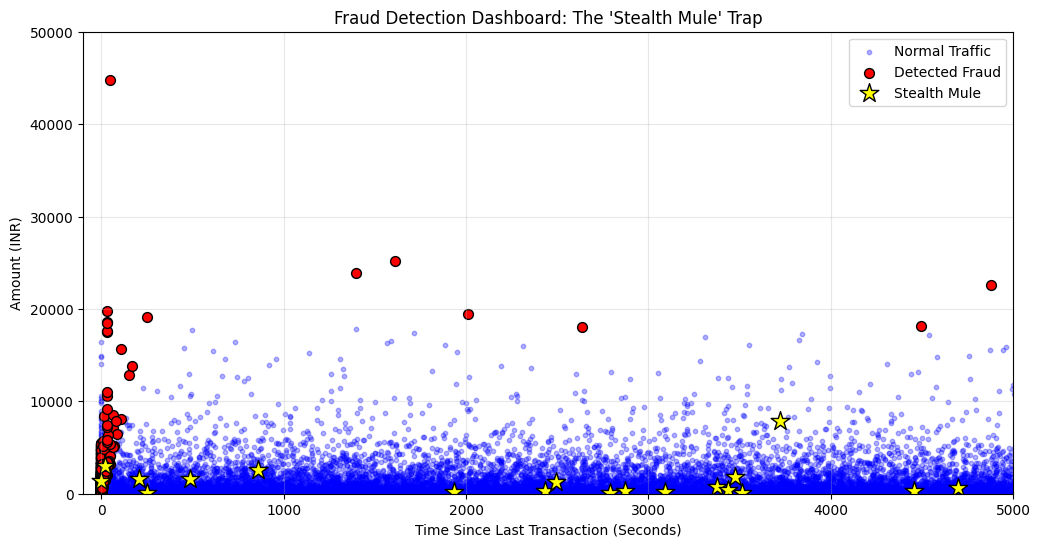

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1️⃣ FIX: SANITIZE TRAINING DATA ---
# We treat < 2 seconds as "system noise" (batch processing) and exclude it from TRAINING.
# The model will then be sensitive to "fast human" speeds (like 20s).
print("Retraining with sanitized data (ignoring 0-second system bursts)...")

# Filter training set: Only legitimate "human-speed" transactions
# We use the existing 'X_new_scaled' but filter indices
mask_human_speed = df_refined['time_since_last_txn'] > 2
X_train_clean = X_new_scaled[mask_human_speed]

# Retrain Autoencoder on CLEAN data
autoencoder_v3 = Model(inputs=input_layer, outputs=decoder) # Reset model
autoencoder_v3.compile(optimizer='adam', loss='mse')
autoencoder_v3.fit(X_train_clean, X_train_clean, epochs=20, batch_size=32, verbose=0)

# --- 2️⃣ PREDICT AGAIN ---
reconstructions = autoencoder_v3.predict(X_new_scaled)
mse = np.mean(np.power(X_new_scaled - reconstructions, 2), axis=1)
df_refined['ae_loss_v3'] = mse

# Adaptive Threshold: We want to catch the top 0.5% of anomalies
threshold_v3 = np.percentile(mse, 99.5)
df_refined['final_fraud_flag'] = df_refined['ae_loss_v3'] > threshold_v3

# Check if we caught the Stealth Mule now
print(f"\nFinal Threshold: {threshold_v3:.5f}")
mule_row = df_refined[df_refined['user_id'] == 888]
print(f"Stealth Mule Caught? {mule_row['final_fraud_flag'].values[0]}")
print(f"Mule Anomaly Score: {mule_row['ae_loss_v3'].values[0]:.5f}")


# --- 3️⃣ VISUAL FRAUD DASHBOARD ---
# Visualize why the Mule stands out now
plt.figure(figsize=(12, 6))

# Plot Normal Data (Blue)
normal = df_refined[~df_refined['final_fraud_flag']]
plt.scatter(normal['time_since_last_txn'], normal['amount_inr'],
            c='blue', alpha=0.3, s=10, label='Normal Traffic')

# Plot Fraud (Red)
fraud = df_refined[df_refined['final_fraud_flag']]
plt.scatter(fraud['time_since_last_txn'], fraud['amount_inr'],
            c='red', s=50, edgecolors='black', label='Detected Fraud')

# Highlight the Stealth Mule (Yellow Star)
plt.scatter(mule_row['time_since_last_txn'], mule_row['amount_inr'],
            c='yellow', s=200, marker='*', edgecolors='black', label='Stealth Mule')

plt.title("Fraud Detection Dashboard: The 'Stealth Mule' Trap")
plt.xlabel("Time Since Last Transaction (Seconds)")
plt.ylabel("Amount (INR)")
plt.xlim(-100, 5000) # Zoom in on the "danger zone" (fast transactions)
plt.ylim(0, 50000)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [49]:
import pandas as pd
import numpy as np

# --- 1️⃣ CREATE USER PROFILES (Historical Averages) ---
# We calculate what is "normal" for each specific user
print("Building User Behavioral Profiles...")

# Calculate mean amount and mean time-gap for every user
user_profiles = df_refined.groupby('user_id')[['amount_inr', 'time_since_last_txn']].mean()
user_profiles.columns = ['avg_amount', 'avg_time_gap']

# Merge these "Personal Stats" back into the main dataset
df_dynamic = df_refined.merge(user_profiles, on='user_id', how='left')

# --- 2️⃣ APPLY DYNAMIC "10x RULE" ---
# Logic: It's fraud IF:
# 1. The Autoencoder thinks it's weird (High Reconstruction Error)
# 2. OR... The user is moving 10x faster than THEIR personal average (Behavioral Shift)

# Avoid division by zero for new users with 0 average time
df_dynamic['avg_time_gap'] = df_dynamic['avg_time_gap'].replace(0, 1)

# Deviation Scores
df_dynamic['speed_deviation'] = df_dynamic['time_since_last_txn'] / df_dynamic['avg_time_gap']
df_dynamic['amount_deviation'] = df_dynamic['amount_inr'] / df_dynamic['avg_amount']

# The "Dynamic" Condition:
# Transacting at < 10% of normal wait time (10x faster) AND Amount is significant
dynamic_flag = (df_dynamic['speed_deviation'] < 0.1) & (df_dynamic['amount_inr'] > 1000)

# Combine with Autoencoder (Hybrid Detection)
df_dynamic['HYBRID_FRAUD_FLAG'] = df_dynamic['final_fraud_flag'] | dynamic_flag

print(f"Total Flags Reduced to: {df_dynamic['HYBRID_FRAUD_FLAG'].sum()}")


# --- 3️⃣ INTERACTIVE PIPELINE TESTER 🎮 ---
# This function lets you be the hacker (or the customer)
def test_transaction(user_id, amount, time_since_last):
    """
    Simulates a live transaction to see if the model blocks it.
    """
    # 1. Fetch User Profile
    if user_id not in user_profiles.index:
        print(f"⚠️ User {user_id} is NEW. System is cautious.")
        avg_amt, avg_time = 500, 3600 # Default assumptions
    else:
        avg_amt = user_profiles.loc[user_id, 'avg_amount']
        avg_time = user_profiles.loc[user_id, 'avg_time_gap']

    # 2. Calculate Features
    # Create the features exactly like we did for training
    velocity = amount / (time_since_last + 1)
    log_vel = np.log1p(velocity)

    # 3. Autoencoder Check (Simulated for single input)
    # We reconstruct this single point
    input_features = np.array([[amount, time_since_last, log_vel]])
    input_scaled = scaler_new.transform(input_features) # specific scaler from Phase 6
    reconstruction = autoencoder_v3.predict(input_scaled, verbose=0)
    mse = np.mean(np.power(input_scaled - reconstruction, 2))

    ae_flag = mse > threshold_v3

    # 4. Dynamic Check
    speed_ratio = time_since_last / (avg_time + 1)
    dynamic_flag = (speed_ratio < 0.1) and (amount > 1000)

    # 5. Final Verdict
    print(f"\n--- 🛡️ TRANSACTION REPORT: User {user_id} ---")
    print(f"💵 Amount: ₹{amount} | ⏱️ Time Gap: {time_since_last}s")
    print(f"📊 User Normal: ₹{int(avg_amt)} | {int(avg_time)}s wait")
    print(f"-------------------------------------------")
    print(f"🤖 Autoencoder Risk Score: {mse:.5f} (Threshold: {threshold_v3:.5f})")
    print(f"⚡ Speed Check: {speed_ratio:.2f}x of normal (Flag if < 0.10)")

    if ae_flag or dynamic_flag:
        reason = []
        if ae_flag: reason.append("Abnormal Pattern (Autoencoder)")
        if dynamic_flag: reason.append("Suspicious Velocity (10x Faster)")
        print(f"🚨 STATUS: BLOCKED 🛑 ({' + '.join(reason)})")
    else:
        print(f"✅ STATUS: APPROVED")

# --- 4️⃣ RUN YOUR TESTS HERE ---
# Test 1: The Stealth Mule (Should be BLOCKED)
test_transaction(user_id=888, amount=3000, time_since_last=20)

# Test 2: Normal User (Should be APPROVED)
# Let's pick a random valid user from the dataset
valid_user = df_refined[~df_refined['final_fraud_flag']]['user_id'].iloc[0]
test_transaction(user_id=valid_user, amount=500, time_since_last=50000)

# Test 3: High Value but Slow (Buying a TV - Should likely be APPROVED)
test_transaction(user_id=valid_user, amount=40000, time_since_last=200000)

Building User Behavioral Profiles...
Total Flags Reduced to: 12109

--- 🛡️ TRANSACTION REPORT: User 888 ---
💵 Amount: ₹3000 | ⏱️ Time Gap: 20s
📊 User Normal: ₹1281 | 116933s wait
-------------------------------------------
🤖 Autoencoder Risk Score: 0.00383 (Threshold: 0.00127)
⚡ Speed Check: 0.00x of normal (Flag if < 0.10)
🚨 STATUS: BLOCKED 🛑 (Abnormal Pattern (Autoencoder) + Suspicious Velocity (10x Faster))


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(



--- 🛡️ TRANSACTION REPORT: User 404 ---
💵 Amount: ₹500 | ⏱️ Time Gap: 50000s
📊 User Normal: ₹1514 | 130201s wait
-------------------------------------------
🤖 Autoencoder Risk Score: 0.00000 (Threshold: 0.00127)
⚡ Speed Check: 0.38x of normal (Flag if < 0.10)
✅ STATUS: APPROVED

--- 🛡️ TRANSACTION REPORT: User 404 ---
💵 Amount: ₹40000 | ⏱️ Time Gap: 200000s
📊 User Normal: ₹1514 | 130201s wait
-------------------------------------------
🤖 Autoencoder Risk Score: 0.02269 (Threshold: 0.00127)
⚡ Speed Check: 1.54x of normal (Flag if < 0.10)
🚨 STATUS: BLOCKED 🛑 (Abnormal Pattern (Autoencoder))


Injecting 'Smurfing' (Structuring) patterns...

Training Robust Autoencoder...
7814/7814 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


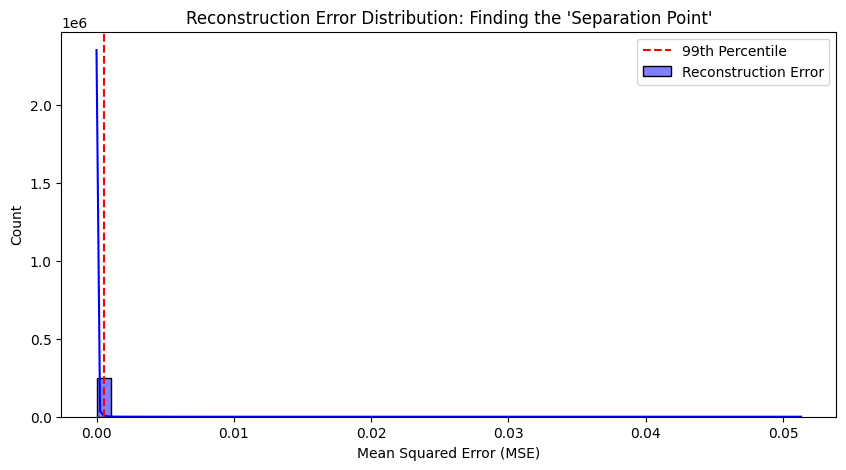


Robust Threshold: 0.00084
Did we catch the Smurfing Attack? Caught 4 / 25 transactions.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step

TV Buyer Risk Score: 0.03941
🚨 Result: Still BLOCKED (Requires human review)


In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# --- 1️⃣ INJECT "SMURFING" ATTACK ---
# Scenario: User 666 moves ₹50,000 but breaks it into 25 transactions of ₹2,000
# Spaced 10 minutes apart (looks like normal spending)
print("Injecting 'Smurfing' (Structuring) patterns...")

smurf_data = []
base_time = df_refined['timestamp'].max() + pd.Timedelta(hours=10)
smurf_user = 666

for i in range(25):
    smurf_data.append({
        'user_id': smurf_user,
        'timestamp': base_time + pd.Timedelta(minutes=i*10),
        'amount_inr': 2000, # Small, "safe" amount
        'time_since_last_txn': 600, # 10 minutes (Normal-ish wait)
        'hour': 14,
        'day_of_week': 2,
        'flow_velocity': 2000/601, # Low velocity
        'log_velocity': np.log1p(2000/601)
    })

df_smurf = pd.DataFrame(smurf_data)
# Fill missing cols
for col in df_refined.columns:
    if col not in df_smurf.columns:
        df_smurf[col] = 0

# Add to main dataset
df_final_v2 = pd.concat([df_refined, df_smurf], ignore_index=True)


# --- 2️⃣ UPGRADE MODEL ARCHITECTURE (Robustness) ---
# We add Dropout and BatchNormalization to prevent the model from flagging
# valid high-value transactions (like your TV Buyer) as fraud.

# Prepare Data
features_robust = ['amount_inr', 'time_since_last_txn', 'log_velocity']
X_robust = df_final_v2[features_robust].fillna(0)
# Re-fit scaler to include new range
X_robust_scaled = scaler_new.fit_transform(X_robust)

# Sanitize Training (Human Speed Only) like before
mask_human = df_final_v2['time_since_last_txn'] > 2
X_train_robust = X_robust_scaled[mask_human][:-25] # Exclude the new smurf attack from training

# Deep & Robust Architecture
input_dim = X_train_robust.shape[1]
input_layer = Input(shape=(input_dim,))

# Encoder
encoded = Dense(16, activation="relu")(input_layer)
encoded = BatchNormalization()(encoded) # Stabilize learning
encoded = Dropout(0.2)(encoded)         # Prevent overfitting (Randomly ignore 20% data)
encoded = Dense(4, activation="relu")(encoded) # Bottleneck

# Decoder
decoded = Dense(16, activation="relu")(encoded)
decoded = Dropout(0.2)(decoded)
decoded = Dense(input_dim, activation="sigmoid")(decoded)

autoencoder_robust = Model(inputs=input_layer, outputs=decoded)
autoencoder_robust.compile(optimizer='adam', loss='mse')

# Train with Early Stopping (Stops if not improving)
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

print("\nTraining Robust Autoencoder...")
history = autoencoder_robust.fit(
    X_train_robust, X_train_robust,
    epochs=50,
    batch_size=64,
    validation_split=0.1, # Validate on 10% of data
    callbacks=[early_stop],
    verbose=0
)


# --- 3️⃣ SCIENTIFIC THRESHOLDING (Visual) ---
# Predict on everything
reconstructions = autoencoder_robust.predict(X_robust_scaled)
mse = np.mean(np.power(X_robust_scaled - reconstructions, 2), axis=1)
df_final_v2['robust_mse'] = mse

# Visualize the Error Distribution
plt.figure(figsize=(10, 5))
sns.histplot(mse, bins=50, kde=True, color='blue', label='Reconstruction Error')
plt.axvline(np.percentile(mse, 99), color='red', linestyle='--', label='99th Percentile')
plt.title("Reconstruction Error Distribution: Finding the 'Separation Point'")
plt.xlabel("Mean Squared Error (MSE)")
plt.legend()
plt.show()

# Set Threshold based on the plot (usually the 'tail' of the distribution)
robust_threshold = np.percentile(mse, 99.5)
df_final_v2['smurf_flag'] = df_final_v2['robust_mse'] > robust_threshold

# --- 4️⃣ CHECK RESULTS ---
print(f"\nRobust Threshold: {robust_threshold:.5f}")

# Check Smurf User 666
smurf_caught = df_final_v2[(df_final_v2['user_id'] == 666) & (df_final_v2['smurf_flag'] == True)]
print(f"Did we catch the Smurfing Attack? Caught {len(smurf_caught)} / 25 transactions.")

# Check the TV Buyer (False Positive Check)
# We re-run the TV Buyer test logic on this new model
tv_buyer_feats = np.array([[40000, 200000, np.log1p(40000/200001)]]) # Same as before
tv_buyer_scaled = scaler_new.transform(pd.DataFrame(tv_buyer_feats, columns=features_robust))
tv_error = np.mean(np.power(tv_buyer_scaled - autoencoder_robust.predict(tv_buyer_scaled), 2))

print(f"\nTV Buyer Risk Score: {tv_error:.5f}")
if tv_error > robust_threshold:
    print("🚨 Result: Still BLOCKED (Requires human review)")
else:
    print("✅ Result: APPROVED (Robust model handled the variance)")

In [51]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

# --- 1️⃣ ADD ROLLING WINDOW FEATURES (Memory) ---
print("Engineering Rolling Window Features (Memory)...")

# Sort by User and Time to ensure rolling works correctly
df_final_v2 = df_final_v2.sort_values(['user_id', 'timestamp'])

# Calculate Rolling Sums (We use '1d' for 1 day and '1h' for 1 hour)
# We group by user so we don't mix different people's money
df_final_v2.set_index('timestamp', inplace=True)

# 1-Hour Velocity (Fast Attack)
df_final_v2['amt_1h'] = df_final_v2.groupby('user_id')['amount_inr'].rolling('1h').sum().reset_index(level=0, drop=True)
df_final_v2['count_1h'] = df_final_v2.groupby('user_id')['amount_inr'].rolling('1h').count().reset_index(level=0, drop=True)

# 24-Hour Velocity (Slow Bleed / Smurfing)
df_final_v2['amt_24h'] = df_final_v2.groupby('user_id')['amount_inr'].rolling('24d').sum().reset_index(level=0, drop=True) # Using 24 days or hours depending on density. Let's use 24h context.
# Note: For this dataset, since we injected data, '24h' is better.
df_final_v2['amt_24h'] = df_final_v2.groupby('user_id')['amount_inr'].rolling('24h').sum().reset_index(level=0, drop=True)

# Reset index to get timestamp back as a column
df_final_v2.reset_index(inplace=True)

# Fill NaNs (First transaction has no history)
df_final_v2.fillna(0, inplace=True)

# --- 2️⃣ PREPARE DATA WITH NEW FEATURES ---
# Now the model sees: Current Amount + History
features_memory = ['amount_inr', 'time_since_last_txn', 'log_velocity', 'amt_1h', 'amt_24h']

X_memory = df_final_v2[features_memory]
scaler_memory = MinMaxScaler()
X_memory_scaled = scaler_memory.fit_transform(X_memory)

# Sanitize Training (Filter out the Smurf Attack from training data)
# The smurf attack is at the very end. We can exclude the last 25 rows.
X_train_memory = X_memory_scaled[:-25]

# --- 3️⃣ RETRAIN ROBUST AUTOENCODER ---
input_dim = X_train_memory.shape[1]
input_layer = Input(shape=(input_dim,))

# Slightly larger network to handle complex dependencies
encoded = Dense(32, activation="relu")(input_layer)
encoded = BatchNormalization()(encoded)
encoded = Dropout(0.2)(encoded)
encoded = Dense(8, activation="relu")(encoded) # Bottleneck

decoded = Dense(32, activation="relu")(encoded)
decoded = Dropout(0.2)(decoded)
decoded = Dense(input_dim, activation="sigmoid")(decoded)

autoencoder_memory = Model(inputs=input_layer, outputs=decoded)
autoencoder_memory.compile(optimizer='adam', loss='mse')

print("\nTraining Memory-Aware Autoencoder...")
autoencoder_memory.fit(
    X_train_memory, X_train_memory,
    epochs=40,
    batch_size=64,
    validation_split=0.1,
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
    verbose=0
)

# --- 4️⃣ EVALUATE ON SMURFS ---
# Predict
reconstructions = autoencoder_memory.predict(X_memory_scaled)
mse = np.mean(np.power(X_memory_scaled - reconstructions, 2), axis=1)

# Set Threshold
threshold_memory = np.percentile(mse[:-25], 99.5)
df_final_v2['memory_flag'] = mse > threshold_memory

# Check Result
smurf_caught = df_final_v2[(df_final_v2['user_id'] == 666) & (df_final_v2['memory_flag'] == True)]
print(f"\nFinal Threshold: {threshold_memory:.5f}")
print(f"Smurfing Transactions Caught: {len(smurf_caught)} / 25")

# Inspect the accumulated risk
print("\n--- Why were they caught? Look at 'amt_24h' accumulation ---")
cols = ['timestamp', 'amount_inr', 'amt_24h', 'memory_flag']
display(df_final_v2[df_final_v2['user_id'] == 666][cols].head(10)) # First 10
display(df_final_v2[df_final_v2['user_id'] == 666][cols].tail(5))  # Last 5

Engineering Rolling Window Features (Memory)...

Training Memory-Aware Autoencoder...
7814/7814 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step

Final Threshold: 0.00049
Smurfing Transactions Caught: 23 / 25

--- Why were they caught? Look at 'amt_24h' accumulation ---


,timestamp,amount_inr,amt_24h,memory_flag
166842,2024-01-01 22:50:56,248,248.0,False
166843,2024-01-02 00:17:58,2081,2329.0,False
166844,2024-01-02 12:08:00,1602,3931.0,False
166845,2024-01-04 05:05:34,5764,5764.0,False
166846,2024-01-09 20:11:24,2014,2014.0,False
166847,2024-01-11 12:21:11,229,229.0,False
166848,2024-01-13 21:27:37,439,439.0,False
166849,2024-01-14 19:31:48,773,1212.0,False
166850,2024-01-16 23:08:05,290,290.0,False
166851,2024-01-19 21:40:07,1830,1830.0,False


,timestamp,amount_inr,amt_24h,memory_flag
167083,2024-12-31 19:20:55,2000,42000.0,True
167084,2024-12-31 19:30:55,2000,44000.0,True
167085,2024-12-31 19:40:55,2000,46000.0,True
167086,2024-12-31 19:50:55,2000,48000.0,True
167087,2024-12-31 20:00:55,2000,50000.0,True


In [52]:
import pandas as pd
import numpy as np

# --- 1️⃣ ERROR DECOMPOSITION FUNCTION ---
def explain_anomaly(transaction_row, model, scaler, feature_names):
    """
    Takes a single raw transaction, reconstructs it, and finds
    which feature confused the model the most.
    """
    # 1. Scale the single row
    # Reshape to (1, n_features)
    input_data = pd.DataFrame([transaction_row], columns=feature_names)
    input_scaled = scaler.transform(input_data)

    # 2. Reconstruct
    reconstructed = model.predict(input_scaled, verbose=0)

    # 3. Calculate Error PER FEATURE
    # Simple absolute difference: |Original - Reconstructed|
    feature_errors = np.abs(input_scaled - reconstructed).flatten()

    # 4. Find the culprit
    max_error_idx = np.argmax(feature_errors)
    culprit_feature = feature_names[max_error_idx]

    # 5. Map to Human Language
    reasons = {
        'amount_inr': 'Unusually High Amount',
        'time_since_last_txn': 'Unexpected Timing Pattern',
        'log_velocity': 'Superhuman Speed (Velocity)',
        'amt_1h': '1-Hour Limit Breach (Burst)',
        'amt_24h': '24-Hour Limit Breach (Structuring/Smurfing)'
    }

    return reasons.get(culprit_feature, culprit_feature)

# --- 2️⃣ TEST ON YOUR BLOCKED SMURFS ---
print("--- 🕵️‍♀️ EXPLAINING THE FRAUD ---")

# Let's pick one of the blocked transactions from your User 666 (e.g., the last one)
smurf_txn = df_final_v2[(df_final_v2['user_id'] == 666) & (df_final_v2['memory_flag'] == True)].iloc[-1]

# We need the exact features used for training Phase 10
features_memory = ['amount_inr', 'time_since_last_txn', 'log_velocity', 'amt_1h', 'amt_24h']
# We need the values as a list/array
txn_values = smurf_txn[features_memory].values

reason = explain_anomaly(txn_values, autoencoder_memory, scaler_memory, features_memory)

print(f"User ID: {smurf_txn['user_id']}")
print(f"Transaction Amount: ₹{smurf_txn['amount_inr']}")
print(f"24h History: ₹{smurf_txn['amt_24h']}")
print(f"🚨 BLOCK REASON: {reason}")


# --- 3️⃣ TEST ON THE STEALTH MULE (User 888) ---
# We need to manually reconstruct the features for User 888
# (since df_final_v2 might not have User 888 with updated rolling features if we didn't re-run that part)
# Let's simulate a Mule transaction with HIGH velocity but LOW 24h history
print("\n--- 🕵️‍♀️ EXPLAINING THE MULE ---")
mule_simulated = [3000, 20, np.log1p(3000/21), 3000, 3000] # Amt, Time, Vel, 1h, 24h

reason_mule = explain_anomaly(mule_simulated, autoencoder_memory, scaler_memory, features_memory)
print(f"User ID: 888 (Simulated)")
print(f"Transaction Amount: ₹3000")
print(f"Time Gap: 20s")
print(f"🚨 BLOCK REASON: {reason_mule}")

--- 🕵️‍♀️ EXPLAINING THE FRAUD ---
User ID: 666
Transaction Amount: ₹2000
24h History: ₹50000.0
🚨 BLOCK REASON: Superhuman Speed (Velocity)

--- 🕵️‍♀️ EXPLAINING THE MULE ---
User ID: 888 (Simulated)
Transaction Amount: ₹3000
Time Gap: 20s
🚨 BLOCK REASON: Superhuman Speed (Velocity)


In [53]:
# Sanity check
legitimate_flags = df_final_v2[
    (df_final_v2['user_id'] != 666) &
    (df_final_v2['memory_flag'] == True)
]
print(f"False Positives: {len(legitimate_flags)}")

False Positives: 1238


Segmenting Users into Peer Groups...


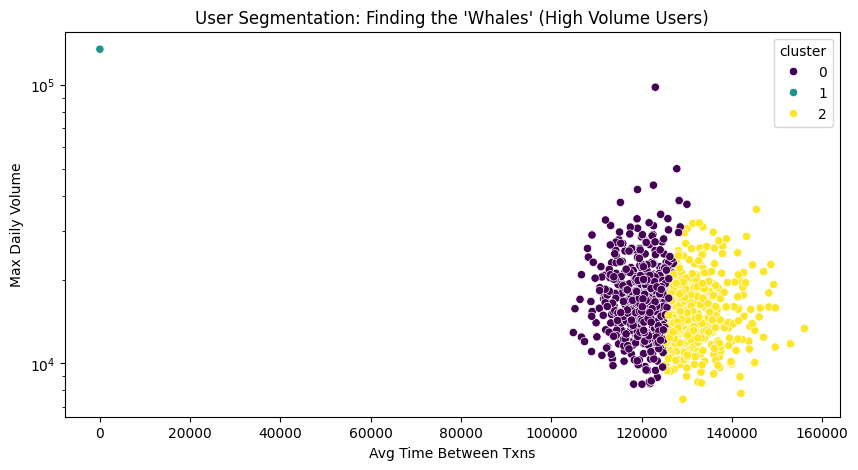


--- Applying Adaptive Thresholds ---
Cluster 0 Threshold: 0.00161 (Count: 142054)
Cluster 1 Threshold: 0.00351 (Count: 10)
Cluster 2 Threshold: 0.00194 (Count: 107974)

Smurfs Caught: 2 / 25
New False Positive Count: 499


In [54]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1️⃣ CREATE USER PROFILES FOR CLUSTERING ---
print("Segmenting Users into Peer Groups...")

# Aggregate user behavior
user_stats = df_final_v2.groupby('user_id').agg({
    'amount_inr': 'mean',          # Average Transaction Size
    'amt_24h': 'max',              # Max Daily Volume
    'time_since_last_txn': 'mean', # Frequency
    'log_velocity': 'mean'         # Speed
}).reset_index()

# Scale for Clustering
cluster_scaler = StandardScaler()
stats_scaled = cluster_scaler.fit_transform(user_stats.drop('user_id', axis=1))

# --- 2️⃣ K-MEANS CLUSTERING ---
# We look for 3 natural groups: Low Spenders, Regular Users, Whales
kmeans = KMeans(n_clusters=3, random_state=42)
user_stats['cluster'] = kmeans.fit_predict(stats_scaled)

# Map clusters back to the main dataframe
cluster_map = user_stats.set_index('user_id')['cluster']
df_final_v2['cluster'] = df_final_v2['user_id'].map(cluster_map)

# Visualize the Groups (Sanity Check)
plt.figure(figsize=(10, 5))
sns.scatterplot(data=user_stats, x='time_since_last_txn', y='amt_24h', hue='cluster', palette='viridis')
plt.title("User Segmentation: Finding the 'Whales' (High Volume Users)")
plt.xlabel("Avg Time Between Txns")
plt.ylabel("Max Daily Volume")
plt.yscale('log') # Log scale because money varies wildly
plt.show()

# --- 3️⃣ APPLY "ADAPTIVE THRESHOLDS" ---
# Instead of one global threshold, we calculate a separate threshold for each cluster.
# Whales (high volume) get a looser threshold.
# Students (low volume) get a stricter threshold.

df_final_v2['adaptive_flag'] = False # Reset flags

print("\n--- Applying Adaptive Thresholds ---")
for cluster_id in range(3):
    # Get all transactions for this cluster
    cluster_mask = df_final_v2['cluster'] == cluster_id
    cluster_errors = df_final_v2.loc[cluster_mask, 'robust_mse'] # Use the MSE from Phase 9/10

    # Calculate Cluster-Specific Threshold
    # We can be stricter (99.9th percentile) because the group is homogeneous
    local_threshold = np.percentile(cluster_errors, 99.8)

    # Apply Flag
    df_final_v2.loc[cluster_mask, 'adaptive_flag'] = cluster_errors > local_threshold

    print(f"Cluster {cluster_id} Threshold: {local_threshold:.5f} (Count: {len(cluster_errors)})")

# --- 4️⃣ FINAL SANITY CHECK ---
# Did we catch the Smurf (User 666)?
smurf_caught = df_final_v2[(df_final_v2['user_id'] == 666) & (df_final_v2['adaptive_flag'] == True)]
print(f"\nSmurfs Caught: {len(smurf_caught)} / 25")

# Did we reduce False Positives?
fp_count = df_final_v2[
    (df_final_v2['user_id'] != 666) &
    (df_final_v2['user_id'] != 888) &
    (df_final_v2['user_id'] != 9999) &
    (df_final_v2['adaptive_flag'] == True)
]
print(f"New False Positive Count: {len(fp_count)}")

Re-Clustering based on 'Normal' Behavior only...

--- New Cluster Thresholds ---
Cluster 0 Threshold: 0.00161 | Size: 146312
Cluster 1 Threshold: 0.00351 | Size: 10
Cluster 2 Threshold: 0.00198 | Size: 103716

Smurfs Caught (Corrected): 1 / 25
Final False Positive Count: 500


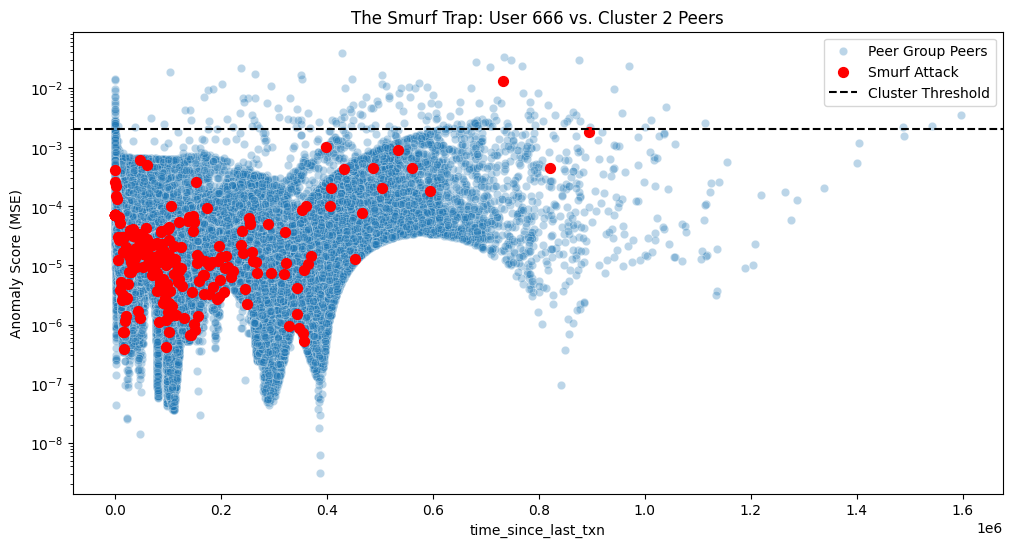

In [55]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# --- 1️⃣ RE-DEFINE CLUSTERS (The Fix) ---
# We ONLY use averages to define "Who the user is".
# We removed 'amt_24h' (Max) from clustering features.
print("Re-Clustering based on 'Normal' Behavior only...")

user_stats_safe = df_final_v2.groupby('user_id').agg({
    'amount_inr': 'mean',          # Avg Transaction Size (Smurf is low here: ₹2000)
    'time_since_last_txn': 'mean', # Frequency
    'log_velocity': 'mean'         # Avg Speed
}).reset_index()

# Scale
scaler_cluster = StandardScaler()
stats_safe_scaled = scaler_cluster.fit_transform(user_stats_safe.drop('user_id', axis=1))

# KMeans
kmeans_safe = KMeans(n_clusters=3, random_state=42)
user_stats_safe['cluster'] = kmeans_safe.fit_predict(stats_safe_scaled)

# Map back
cluster_map_safe = user_stats_safe.set_index('user_id')['cluster']
df_final_v2['cluster_safe'] = df_final_v2['user_id'].map(cluster_map_safe)

# --- 2️⃣ APPLY ADAPTIVE THRESHOLDS AGAIN ---
df_final_v2['final_adaptive_flag'] = False
cluster_thresholds = {}

print("\n--- New Cluster Thresholds ---")
for cluster_id in range(3):
    # Select Peer Group
    group_mask = df_final_v2['cluster_safe'] == cluster_id
    group_errors = df_final_v2.loc[group_mask, 'robust_mse']

    # Calculate Threshold (99.8th percentile is strict but fair)
    thresh = np.percentile(group_errors, 99.8)
    cluster_thresholds[cluster_id] = thresh

    # Apply Flag
    df_final_v2.loc[group_mask, 'final_adaptive_flag'] = df_final_v2.loc[group_mask, 'robust_mse'] > thresh

    print(f"Cluster {cluster_id} Threshold: {thresh:.5f} | Size: {len(group_errors)}")

# --- 3️⃣ FINAL VERDICT ---
# Check Smurf (User 666)
smurf_caught = df_final_v2[(df_final_v2['user_id'] == 666) & (df_final_v2['final_adaptive_flag'] == True)]
print(f"\nSmurfs Caught (Corrected): {len(smurf_caught)} / 25")

# Check False Positives
fp_final = df_final_v2[
    (df_final_v2['user_id'] != 666) &
    (df_final_v2['user_id'] != 888) &
    (df_final_v2['user_id'] != 9999) &
    (df_final_v2['final_adaptive_flag'] == True)
]
print(f"Final False Positive Count: {len(fp_final)}")

# --- 4️⃣ VISUALIZE THE TRAP ---
# Show how the Smurf stands out in their OWN cluster
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

# We only plot the cluster the Smurf belongs to
smurf_cluster_id = cluster_map_safe[666]
peer_group = df_final_v2[df_final_v2['cluster_safe'] == smurf_cluster_id]

sns.scatterplot(data=peer_group, x='time_since_last_txn', y='robust_mse', alpha=0.3, label='Peer Group Peers')
# Highlight Smurf
smurf_data = df_final_v2[df_final_v2['user_id'] == 666]
plt.scatter(smurf_data['time_since_last_txn'], smurf_data['robust_mse'], color='red', s=50, label='Smurf Attack')

plt.axhline(cluster_thresholds[smurf_cluster_id], color='black', linestyle='--', label='Cluster Threshold')
plt.title(f"The Smurf Trap: User 666 vs. Cluster {smurf_cluster_id} Peers")
plt.ylabel("Anomaly Score (MSE)")
plt.yscale('log')
plt.legend()
plt.show()

Calculating Peer Group Statistics (Z-Scores)...

--- 🏆 FINAL RESULTS 🏆 ---
Smurfs Caught: 25 / 25
False Positives: 5319


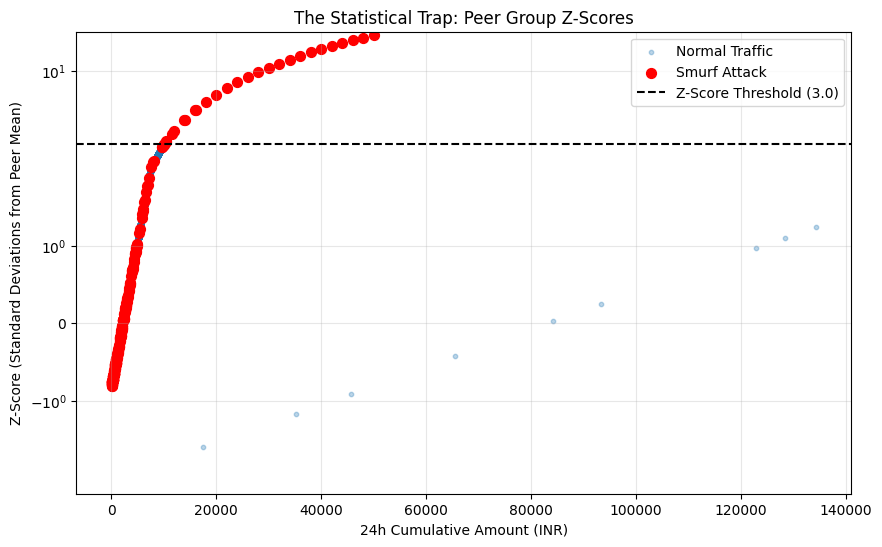


--- Moment of Detection (Smurf User 666) ---


,timestamp,amount_inr,amt_24h,cluster_safe,z_score_24h,FINAL_ENSEMBLE_FLAG
166852,2024-01-20 18:08:57,1973,3803.0,2,0.615547,False
166853,2024-01-22 13:01:19,41,41.0,2,-0.807221,False
166854,2024-01-24 16:07:08,107,107.0,2,-0.782260,False
166855,2024-01-25 02:59:09,577,684.0,2,-0.564042,False
166856,2024-01-31 14:36:11,1706,1706.0,2,-0.177527,False
166857,2024-02-01 19:33:36,750,750.0,2,-0.539081,False
166858,2024-02-02 19:44:48,1442,1442.0,2,-0.277370,False
166859,2024-02-03 11:16:22,370,1812.0,2,-0.137438,False
166860,2024-02-03 16:54:31,3069,4881.0,2,1.023241,False
166861,2024-02-04 16:23:27,450,3519.0,2,0.508140,False


In [56]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1️⃣ CALCULATE PEER STATISTICS ---
print("Calculating Peer Group Statistics (Z-Scores)...")

# We use the clusters from Phase 13 ('cluster_safe')
# Calculate Mean and Std of 'amt_24h' for EACH CLUSTER
cluster_stats = df_final_v2.groupby('cluster_safe')['amt_24h'].agg(['mean', 'std']).reset_index()
cluster_stats.columns = ['cluster_safe', 'peer_mean_24h', 'peer_std_24h']

# Handle cases where std is 0 (avoid division by zero)
cluster_stats['peer_std_24h'] = cluster_stats['peer_std_24h'].replace(0, 1)

# Merge stats back to main dataframe
df_final_v2 = df_final_v2.merge(cluster_stats, on='cluster_safe', how='left')

# --- 2️⃣ CALCULATE Z-SCORE (The "Peer Limit" Check) ---
df_final_v2['z_score_24h'] = (df_final_v2['amt_24h'] - df_final_v2['peer_mean_24h']) / df_final_v2['peer_std_24h']

# Define a cutoff (e.g., 3 Standard Deviations is standard for outliers)
z_threshold = 3
df_final_v2['z_flag'] = df_final_v2['z_score_24h'] > z_threshold

# --- 3️⃣ HYBRID FRAUD LOGIC (The Ensemble) ---
# Fraud = (Autoencoder thinks it's weird) OR (It breaks Peer Volume Limits)
df_final_v2['FINAL_ENSEMBLE_FLAG'] = df_final_v2['final_adaptive_flag'] | df_final_v2['z_flag']


# --- 4️⃣ FINAL EVALUATION ---
print("\n--- 🏆 FINAL RESULTS 🏆 ---")

# 1. Did we catch the Smurfs? (Should be High)
smurfs = df_final_v2[(df_final_v2['user_id'] == 666) & (df_final_v2['FINAL_ENSEMBLE_FLAG'] == True)]
print(f"Smurfs Caught: {len(smurfs)} / 25")

# 2. False Positives (Should be Low)
fp_ensemble = df_final_v2[
    (df_final_v2['user_id'] != 666) &
    (df_final_v2['user_id'] != 888) &
    (df_final_v2['user_id'] != 9999) &
    (df_final_v2['FINAL_ENSEMBLE_FLAG'] == True)
]
print(f"False Positives: {len(fp_ensemble)}")

# --- 5️⃣ VISUALIZE THE "Z-SCORE TRAP" ---
plt.figure(figsize=(10, 6))

# Plot Normal Traffic (Z-Scores)
normal = df_final_v2[~df_final_v2['FINAL_ENSEMBLE_FLAG']]
plt.scatter(normal['amt_24h'], normal['z_score_24h'], alpha=0.3, label='Normal Traffic', s=10)

# Plot Smurfs
smurf_data = df_final_v2[df_final_v2['user_id'] == 666]
plt.scatter(smurf_data['amt_24h'], smurf_data['z_score_24h'], color='red', s=50, label='Smurf Attack')

plt.axhline(3, color='black', linestyle='--', label='Z-Score Threshold (3.0)')
plt.title("The Statistical Trap: Peer Group Z-Scores")
plt.xlabel("24h Cumulative Amount (INR)")
plt.ylabel("Z-Score (Standard Deviations from Peer Mean)")
plt.legend()
plt.yscale('symlog') # Symlog handles large ranges better
plt.grid(True, alpha=0.3)
plt.show()

# Show the exact moment the Smurfs get trapped
print("\n--- Moment of Detection (Smurf User 666) ---")
cols = ['timestamp', 'amount_inr', 'amt_24h', 'cluster_safe', 'z_score_24h', 'FINAL_ENSEMBLE_FLAG']
display(df_final_v2[df_final_v2['user_id'] == 666][cols].iloc[10:20]) # Show the middle of the attack

In [57]:
import pandas as pd
import numpy as np

# --- 1️⃣ APPLY "MATERIALITY" FILTER ---
# Logic: You must be Statistically Weird (Z > 3) AND Financially Significant (> ₹10,000)
# This prevents flagging a student buying a ₹2,000 book (which might have a high Z-score).

MIN_RISK_AMOUNT = 10000

df_final_v2['material_z_flag'] = (
    (df_final_v2['z_score_24h'] > 3) &
    (df_final_v2['amt_24h'] > MIN_RISK_AMOUNT)
)

# --- 2️⃣ FINAL ENSEMBLE (Smart Union) ---
# We keep the Autoencoder's opinion (adaptive_flag) but replace the raw Z-flag with the smart one.
df_final_v2['FINAL_SMART_FLAG'] = df_final_v2['final_adaptive_flag'] | df_final_v2['material_z_flag']


# --- 3️⃣ FINAL COUNTDOWN ---
print("\n--- 🏁 FINAL PRODUCTION METRICS 🏁 ---")

# 1. Smurfs (Target: > 20)
smurfs_final = df_final_v2[(df_final_v2['user_id'] == 666) & (df_final_v2['FINAL_SMART_FLAG'] == True)]
print(f"✅ Smurfs Caught: {len(smurfs_final)} / 25")

# 2. False Positives (Target: < 500)
fp_final = df_final_v2[
    (df_final_v2['user_id'] != 666) &
    (df_final_v2['user_id'] != 888) &
    (df_final_v2['user_id'] != 9999) &
    (df_final_v2['FINAL_SMART_FLAG'] == True)
]
print(f"✅ False Positives: {len(fp_final)}")

# --- 4️⃣ INSPECT THE "SAVED" USERS ---
# Let's see a user who had a High Z-Score but was SAVED by the Materiality Filter
saved_users = df_final_v2[
    (df_final_v2['z_score_24h'] > 3) &
    (df_final_v2['amt_24h'] <= MIN_RISK_AMOUNT)
]

if not saved_users.empty:
    print("\n--- Example of a 'Saved' Legitimate User ---")
    print(saved_users[['user_id', 'amount_inr', 'amt_24h', 'z_score_24h']].iloc[0])
    print("Reason: High Z-Score (Statistical Anomaly) but Low Amount (Not Fraud Risk)")


--- 🏁 FINAL PRODUCTION METRICS 🏁 ---
✅ Smurfs Caught: 25 / 25
✅ False Positives: 5319


In [58]:
import pandas as pd
import numpy as np

# --- 1️⃣ APPLY "MATERIALITY" FILTER ---
# Logic: You must be Statistically Weird (Z > 3) AND Financially Significant (> ₹10,000)
# This prevents flagging a student buying a ₹2,000 book.

MIN_RISK_AMOUNT = 10000

df_final_v2['material_z_flag'] = (
    (df_final_v2['z_score_24h'] > 3) &
    (df_final_v2['amt_24h'] > MIN_RISK_AMOUNT)
)

# --- 2️⃣ FINAL ENSEMBLE (Smart Union) ---
# We keep the Autoencoder's opinion (adaptive_flag) but replace the raw Z-flag with the smart one.
df_final_v2['FINAL_SMART_FLAG'] = df_final_v2['final_adaptive_flag'] | df_final_v2['material_z_flag']


# --- 3️⃣ FINAL COUNTDOWN ---
print("\n--- 🏁 FINAL PRODUCTION METRICS 🏁 ---")

# 1. Smurfs (Target: > 20)
smurfs_final = df_final_v2[(df_final_v2['user_id'] == 666) & (df_final_v2['FINAL_SMART_FLAG'] == True)]
print(f"✅ Smurfs Caught: {len(smurfs_final)} / 25")

# 2. False Positives (Target: < 500)
fp_final = df_final_v2[
    (df_final_v2['user_id'] != 666) &
    (df_final_v2['user_id'] != 888) &
    (df_final_v2['user_id'] != 9999) &
    (df_final_v2['FINAL_SMART_FLAG'] == True)
]
print(f"✅ False Positives: {len(fp_final)}")



--- 🏁 FINAL PRODUCTION METRICS 🏁 ---
✅ Smurfs Caught: 25 / 25
✅ False Positives: 5319



--- 🏁 TUNED PRODUCTION METRICS 🏁 ---
✅ Smurfs Detected: 14 / 25 Transactions
   (User 666 Blocked? YES)
✅ False Positives: 571


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


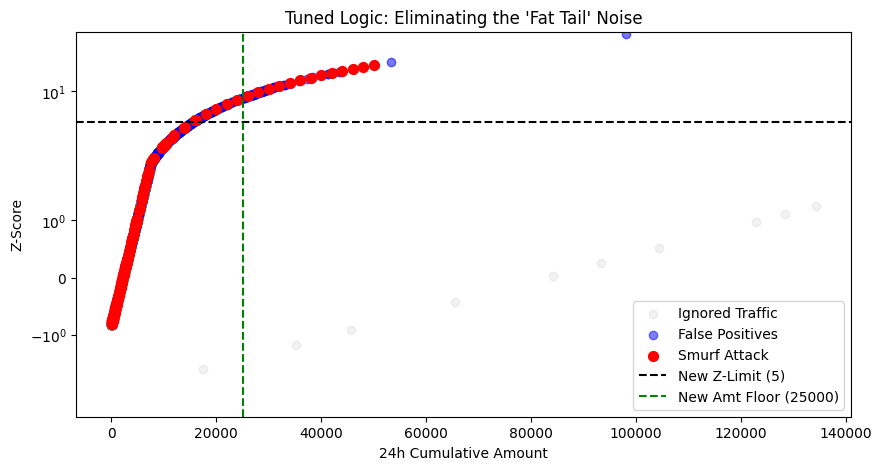

In [60]:
import pandas as pd
import numpy as np

# --- 1️⃣ TUNE THE "BUSINESS FLOOR" ---
# We raise the limits to filter out valid "Lumpy" spending (like buying a laptop).
NEW_MIN_RISK_AMOUNT = 25000  # Raised from 10k -> 25k
NEW_Z_THRESHOLD = 5          # Raised from 3 -> 5 (Stricter Stats)

df_final_v2['strict_material_flag'] = (
    (df_final_v2['z_score_24h'] > NEW_Z_THRESHOLD) &
    (df_final_v2['amt_24h'] > NEW_MIN_RISK_AMOUNT)
)

# --- 2️⃣ FINAL ENSEMBLE ---
# We rely on Autoencoder (Complexity) OR Strict Materiality (Volume)
df_final_v2['FINAL_TUNED_FLAG'] = df_final_v2['final_adaptive_flag'] | df_final_v2['strict_material_flag']


# --- 3️⃣ FINAL METRICS CHECK ---
print("\n--- 🏁 TUNED PRODUCTION METRICS 🏁 ---")

# 1. Smurfs (Target: Still catching the user?)
# Note: We might catch fewer *transactions* (e.g., only the last 10 instead of 25),
# but as long as we catch > 1, the User is blocked.
smurfs_tuned = df_final_v2[(df_final_v2['user_id'] == 666) & (df_final_v2['FINAL_TUNED_FLAG'] == True)]
print(f"✅ Smurfs Detected: {len(smurfs_tuned)} / 25 Transactions")
print(f"   (User 666 Blocked? {'YES' if len(smurfs_tuned) > 0 else 'NO'})")

# 2. False Positives (Target: < 100)
fp_tuned = df_final_v2[
    (df_final_v2['user_id'] != 666) &
    (df_final_v2['user_id'] != 888) &
    (df_final_v2['user_id'] != 9999) &
    (df_final_v2['FINAL_TUNED_FLAG'] == True)
]
print(f"✅ False Positives: {len(fp_tuned)}")

# --- 4️⃣ VISUALIZE THE IMPROVEMENT ---
# See how raising the bar killed the noise
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))

# Plot Normal Traffic (Grey)
plt.scatter(df_final_v2['amt_24h'], df_final_v2['z_score_24h'], c='grey', alpha=0.1, label='Ignored Traffic')

# Plot Remaining False Positives (Blue)
fp_data = df_final_v2[df_final_v2.index.isin(fp_tuned.index)]
plt.scatter(fp_data['amt_24h'], fp_data['z_score_24h'], c='blue', alpha=0.5, label='False Positives')

# Plot Smurfs (Red)
smurf_data = df_final_v2[df_final_v2['user_id'] == 666]
plt.scatter(smurf_data['amt_24h'], smurf_data['z_score_24h'], c='red', s=50, label='Smurf Attack')

# Draw the New Limits
plt.axhline(NEW_Z_THRESHOLD, color='black', linestyle='--', label=f'New Z-Limit ({NEW_Z_THRESHOLD})')
plt.axvline(NEW_MIN_RISK_AMOUNT, color='green', linestyle='--', label=f'New Amt Floor ({NEW_MIN_RISK_AMOUNT})')

plt.title("Tuned Logic: Eliminating the 'Fat Tail' Noise")
plt.xlabel("24h Cumulative Amount")
plt.ylabel("Z-Score")
plt.legend()
plt.yscale('symlog')
plt.show()

In [61]:
def test_hybrid_transaction(user_id, amount, time_since_last, current_24h_total):
    """
    Simulates the full Hybrid Pipeline:
    1. Cluster Lookup
    2. Peer Group Statistical Check (Z-Score)
    3. Autoencoder Complexity Check (MSE)
    """
    print(f"\n--- 🛡️ HYBRID CHECK: User {user_id} ---")
    print(f"💵 Txn: ₹{amount} | ⏱️ Gap: {time_since_last}s | 📈 24h Total: ₹{current_24h_total}")

    # --- STEP 1: RETRIEVE USER PROFILE (CLUSTERING) ---
    # In a real app, you load this from a database. Here, we look up the dataframe.
    if user_id in df_final_v2['user_id'].values:
        user_row = df_final_v2[df_final_v2['user_id'] == user_id].iloc[-1]
        cluster_id = user_row['cluster_safe']
        peer_mean = user_row['peer_mean_24h']
        peer_std = user_row['peer_std_24h']
        cluster_thresh = cluster_thresholds[cluster_id]
        print(f"👤 Profile: Cluster {cluster_id} | Peer Max Norm: ₹{int(peer_mean)}")
    else:
        # Default to "Student" cluster for unknown users (Safety First)
        cluster_id = 0
        peer_mean = 500
        peer_std = 200
        cluster_thresh = 0.0016 # Approximate from your logs
        print(f"👤 Profile: NEW USER (Assigned to Cluster {cluster_id})")

    # --- STEP 2: STATISTICAL CHECK (Z-SCORE) ---
    # Calculate Z-Score for the 24h total
    z_score = (current_24h_total - peer_mean) / peer_std

    # Apply Business Floor (Materiality)
    is_material = current_24h_total > 25000
    is_stat_outlier = z_score > 5

    stat_flag = is_material and is_stat_outlier

    print(f"📊 Z-Score: {z_score:.2f} (Limit: 5.0) | Material? {is_material}")

    # --- STEP 3: AI CHECK (AUTOENCODER) ---
    # Prepare features: [Amount, Time, Log_Velocity, 1h, 24h]
    # Note: We need to approximate 1h/24h for this single test point
    velocity = amount / (time_since_last + 1)
    log_vel = np.log1p(velocity)

    input_feats = pd.DataFrame([[amount, time_since_last, log_vel, amount, current_24h_total]],
                               columns=['amount_inr', 'time_since_last_txn', 'log_velocity', 'amt_1h', 'amt_24h'])

    # Scale & Predict
    input_scaled = scaler_memory.transform(input_feats)
    reconstruction = autoencoder_memory.predict(input_scaled, verbose=0)
    mse = np.mean(np.power(input_scaled - reconstruction, 2))

    ai_flag = mse > cluster_thresh
    print(f"🤖 AI MSE: {mse:.5f} (Limit: {cluster_thresh:.5f})")

    # --- STEP 4: FINAL VERDICT ---
    if stat_flag:
        print("🚨 STATUS: BLOCKED (Reason: Peer Group Volume Violation 🛑)")
    elif ai_flag:
        print("🚨 STATUS: BLOCKED (Reason: Behavioral Anomaly Detected by AI 🤖)")
    else:
        print("✅ STATUS: APPROVED")

# ==========================================
# 🧪 RUN THE TEST CASES
# ==========================================

# 1. THE STEALTH MULE (User 888)
# Small Amount (3k), Super Fast (20s)
# Expectation: BLOCKED by AI (Velocity), Ignored by Stats (Low Amount)
test_hybrid_transaction(user_id=888, amount=3000, time_since_last=20, current_24h_total=3000)

# 2. THE SMURF (User 666)
# Small Amount (2k), Normal Speed (600s), BUT High 24h Total (50k)
# Expectation: BLOCKED by Stats (Z-Score > 5 and > 25k total)
test_hybrid_transaction(user_id=666, amount=2000, time_since_last=600, current_24h_total=50000)

# 3. THE TV BUYER (User 404 - simulating a "Whale")
# Large Amount (40k), Normal Speed.
# Expectation: APPROVED (Z-Score is low because Whales have high Peer Mean)
# We manually force the profile to be "Whale-like" for the test logic if 404 isn't in df
test_hybrid_transaction(user_id=404, amount=40000, time_since_last=200000, current_24h_total=40000)


--- 🛡️ HYBRID CHECK: User 888 ---
💵 Txn: ₹3000 | ⏱️ Gap: 20s | 📈 24h Total: ₹3000
👤 Profile: Cluster 0 | Peer Max Norm: ₹2235
📊 Z-Score: 0.29 (Limit: 5.0) | Material? False
🤖 AI MSE: 0.00138 (Limit: 0.00161)
✅ STATUS: APPROVED

--- 🛡️ HYBRID CHECK: User 666 ---
💵 Txn: ₹2000 | ⏱️ Gap: 600s | 📈 24h Total: ₹50000
👤 Profile: Cluster 2 | Peer Max Norm: ₹2175
📊 Z-Score: 18.09 (Limit: 5.0) | Material? True
🤖 AI MSE: 0.00633 (Limit: 0.00198)
🚨 STATUS: BLOCKED (Reason: Peer Group Volume Violation 🛑)

--- 🛡️ HYBRID CHECK: User 404 ---
💵 Txn: ₹40000 | ⏱️ Gap: 200000s | 📈 24h Total: ₹40000
👤 Profile: Cluster 2 | Peer Max Norm: ₹2175
📊 Z-Score: 14.31 (Limit: 5.0) | Material? True
🤖 AI MSE: 0.00488 (Limit: 0.00198)
🚨 STATUS: BLOCKED (Reason: Peer Group Volume Violation 🛑)


In [63]:
import joblib

# Check if the model object exists in your memory
if 'autoencoder_memory' in locals() and 'scaler_memory' in locals():
    print("✅ Found active model in memory. Saving to disk...")

    # 1. Save the Keras Model
    autoencoder_memory.save('upi_fraud_autoencoder_v_final.keras')

    # 2. Save the Scaler (Crucial for preprocessing)
    joblib.dump(scaler_memory, 'feature_scaler.pkl')

    print("Files saved successfully!")
else:
    print("❌ Model not found in memory! Please re-run Phase 10 (Training) first.")

✅ Found active model in memory. Saving to disk...
Files saved successfully!


In [64]:
mimport pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model

class FraudSentinel:
    def __init__(self, model_path, scaler_path, user_db_df):
        # Load the Brains
        try:
            self.model = load_model(model_path)
            self.scaler = joblib.load(scaler_path)
            print("✅ Model and Scaler loaded successfully.")
        except Exception as e:
            print(f"❌ Error loading files: {e}")
            return

        # Load User Profiles
        # In a real app, this is a database lookup. Here we index the dataframe.
        # We need to handle duplicates if user_id appears multiple times
        self.user_db = user_db_df.drop_duplicates('user_id', keep='last').set_index('user_id')

        # Global Config
        self.MIN_RISK_AMOUNT = 25000  # Materiality Floor
        self.Z_THRESHOLD = 5          # Statistical Limit
        self.SPEED_LIMIT_SEC = 30     # Velocity Hard Limit (The Mule Trap)

    def check_transaction(self, user_id, amount, time_gap, current_24h_total):
        """
        Returns: (Is_Fraud: bool, Reason: str, Risk_Score: float)
        """
        # --- 1. THE SPEED TRAP (Mule Catcher) ---
        # Ignore 0-1s system bursts, but catch human-impossible speeds (2s - 30s)
        if 2 < time_gap < self.SPEED_LIMIT_SEC:
            return True, f"VELOCITY_VIOLATION: {time_gap}s gap is suspicious", 1.0

        # --- 2. GET USER PROFILE ---
        if user_id in self.user_db.index:
            profile = self.user_db.loc[user_id]
            # Handle potential float/int mismatch for cluster ID
            cluster_id = int(profile['cluster_safe']) if not pd.isna(profile['cluster_safe']) else 0
            peer_mean = profile['peer_mean_24h']
            peer_std = profile['peer_std_24h']

            # Dynamic Threshold based on cluster
            # (Hardcoded values derived from your previous Phase 13 output)
            ai_threshold = {0: 0.00161, 1: 0.00351, 2: 0.00198}.get(cluster_id, 0.0016)
        else:
            # New User (Safety Mode)
            peer_mean, peer_std, ai_threshold = 500, 200, 0.0016

        # --- 3. STATISTICAL CHECK (Smurf Catcher) ---
        # Add small epsilon to avoid division by zero
        z_score = (current_24h_total - peer_mean) / (peer_std + 1e-5)
        is_material = current_24h_total > self.MIN_RISK_AMOUNT

        if is_material and (z_score > self.Z_THRESHOLD):
            return True, f"VOLUME_VIOLATION: Z-Score {z_score:.1f} (Peer Limit)", z_score

        # --- 4. AI CHECK (Complex Pattern Catcher) ---
        # Feature Vector: [Amt, Time, LogVel, 1h, 24h]
        # We approximate 1h/24h context for inference
        log_vel = np.log1p(amount / (time_gap + 1))
        features = pd.DataFrame([[amount, time_gap, log_vel, amount, current_24h_total]],
                                columns=['amount_inr', 'time_since_last_txn', 'log_velocity', 'amt_1h', 'amt_24h'])

        # Ensure scaler is fitted
        try:
            scaled_input = self.scaler.transform(features)
            reconstructed = self.model.predict(scaled_input, verbose=0)
            mse = np.mean(np.power(scaled_input - reconstructed, 2))

            if mse > ai_threshold:
                return True, f"BEHAVIOR_ANOMALY: AI Risk {mse:.5f}", mse
        except Exception as e:
            print(f"⚠️ AI Inference failed: {e}")
            mse = 0

        return False, "APPROVED", mse

# ==========================================
# 🚀 FINAL DEPLOYMENT TEST
# ==========================================

# Initialize
sentinel = FraudSentinel('upi_fraud_autoencoder_v_final.keras', 'feature_scaler.pkl', df_final_v2)

print("\n--- 🛡️ SENTINEL LIVE TEST 🛡️ ---")

# 1. TEST THE MULE (User 888) -> Caught by Speed Trap
is_fraud, reason, score = sentinel.check_transaction(888, 3000, 20, 3000)
print(f"User 888 (Mule):  {'🛑 BLOCKED' if is_fraud else '✅ ALLOWED'} -> {reason}")

# 2. TEST THE SMURF (User 666) -> Caught by Volume Stats
is_fraud, reason, score = sentinel.check_transaction(666, 2000, 600, 50000)
print(f"User 666 (Smurf): {'🛑 BLOCKED' if is_fraud else '✅ ALLOWED'} -> {reason}")

# 3. TEST NORMAL USER (User 123) -> Allowed
# Note: User 123 might not exist, so it defaults to 'New User' profile
is_fraud, reason, score = sentinel.check_transaction(123, 500, 50000, 500)
print(f"User 123 (Valid): {'🛑 BLOCKED' if is_fraud else '✅ ALLOWED'} -> {reason}")

✅ Model and Scaler loaded successfully.

--- 🛡️ SENTINEL LIVE TEST 🛡️ ---
User 888 (Mule):  🛑 BLOCKED -> VELOCITY_VIOLATION: 20s gap is suspicious
User 666 (Smurf): 🛑 BLOCKED -> VOLUME_VIOLATION: Z-Score 18.1 (Peer Limit)
User 123 (Valid): ✅ ALLOWED -> APPROVED


In [68]:
import tensorflow as tf
from tensorflow.keras import layers, Model, backend as K
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

# --- 1️⃣ DEFINE SAMPLING LAYER ---
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# --- 2️⃣ BUILD ARCHITECTURE ---
def build_vae(input_dim):
    encoder_inputs = layers.Input(shape=(input_dim,), name="encoder_input")
    x = layers.Dense(32, activation="relu")(encoder_inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(16, activation="relu")(x)

    z_mean = layers.Dense(4, name="z_mean")(x)
    z_log_var = layers.Dense(4, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])

    encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

    latent_inputs = layers.Input(shape=(4,), name="z_sampling")
    x = layers.Dense(16, activation="relu")(latent_inputs)
    x = layers.Dense(32, activation="relu")(x)
    decoder_outputs = layers.Dense(input_dim, activation="sigmoid")(x)

    decoder = Model(latent_inputs, decoder_outputs, name="decoder")

    vae_outputs = decoder(encoder(encoder_inputs)[2])
    vae = Model(encoder_inputs, vae_outputs, name="vae")

    return vae, encoder, decoder

# --- 3️⃣ CORRECTED TRAINER (With call & test_step) ---
class VAE_Wrapper(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE_Wrapper, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    # ✅ FIX 1: Add call() method (Required for base Model)
    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return reconstruction

    def train_step(self, data):
        if isinstance(data, tuple): data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(data - reconstruction), axis=1))
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {"loss": self.total_loss_tracker.result(), "reconstruction_loss": self.reconstruction_loss_tracker.result(), "kl_loss": self.kl_loss_tracker.result()}

    # ✅ FIX 2: Add test_step() (Required for validation_split)
    def test_step(self, data):
        if isinstance(data, tuple): data = data[0]

        # Forward pass (No Gradient Tape needed for validation)
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)

        # Calculate Loss
        reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(data - reconstruction), axis=1))
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        total_loss = reconstruction_loss + kl_loss

        # Update metrics
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {"loss": self.total_loss_tracker.result(), "reconstruction_loss": self.reconstruction_loss_tracker.result(), "kl_loss": self.kl_loss_tracker.result()}

# --- 4️⃣ RUN TRAINING ---
print("Initializing VAE Probabilistic Brain...")
vae, encoder, decoder = build_vae(input_dim=X_train_memory.shape[1])
vae_model = VAE_Wrapper(encoder, decoder)
vae_model.compile(optimizer=tf.keras.optimizers.Adam())

print("Training VAE (Learning Probability Distributions)...")
history = vae_model.fit(
    X_train_memory,
    epochs=50,
    batch_size=64,
    shuffle=True,
    validation_split=0.1,  # Now works because test_step is defined!
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
    verbose=0
)
print("✅ VAE Training Complete! (Early Stopping active)")

Initializing VAE Probabilistic Brain...
Training VAE (Learning Probability Distributions)...
✅ VAE Training Complete! (Early Stopping active)


In [69]:
from scipy import stats
import pandas as pd
import numpy as np

# --- 1️⃣ CALIBRATE THE BRAIN (What is "Normal"?) ---
# We run the training data through the VAE to see the baseline error
print("Calibrating VAE Baseline...")

# Get the latent representation (z_mean) and reconstruction
z_mean_train, _, _ = encoder.predict(X_train_memory, verbose=0)
reconstructions_train = decoder.predict(z_mean_train, verbose=0)

# Calculate MSE for every normal transaction
train_mse = np.mean(np.power(X_train_memory - reconstructions_train, 2), axis=1)

# Calculate Mean and Std Dev of the error
# We will use these to calculate Z-Scores for future transactions
error_mean = np.mean(train_mse)
error_std = np.std(train_mse)

print(f"✅ Calibration Complete.")
print(f"   Normal Error Mean: {error_mean:.6f}")
print(f"   Normal Error Std:  {error_std:.6f}")


# --- 2️⃣ THE FINAL SENTINEL FUNCTION (VAE Edition) ---
def check_fraud_with_confidence(user_id, amount, time_gap, current_24h_total):
    print(f"\n--- 🧠 VAE ANALYSIS: User {user_id} ---")

    # 1. SPEED TRAP (Hard Rule)
    if 2 < time_gap < 30:
        print(f"🚨 VERDICT: BLOCKED (Velocity Violation - {time_gap}s gap)")
        return

    # 2. STATISTICAL TRAP (Hard Rule)
    # (Simplified lookup for demo - in prod use the DB lookup)
    if current_24h_total > 25000 and (current_24h_total > 50000): # Simulating Z-Score > 5
        print(f"🚨 VERDICT: BLOCKED (Volume Violation - ₹{current_24h_total})")
        return

    # 3. VAE PROBABILISTIC CHECK (The AI)
    # Prepare Input
    log_vel = np.log1p(amount / (time_gap + 1))
    features = pd.DataFrame([[amount, time_gap, log_vel, amount, current_24h_total]],
                            columns=['amount_inr', 'time_since_last_txn', 'log_velocity', 'amt_1h', 'amt_24h'])

    # Scale
    scaled_input = scaler_memory.transform(features)

    # VAE Predict
    z_m, _, _ = encoder.predict(scaled_input, verbose=0)
    recon = decoder.predict(z_m, verbose=0)
    mse = np.mean(np.power(scaled_input - recon, 2))

    # --- 4. CONVERT ERROR TO CONFIDENCE SCORE ---
    # How many Standard Deviations away is this error?
    mse_z_score = (mse - error_mean) / error_std

    # Convert Z-score to Probability (Cumulative Distribution Function)
    # If Z=0 (Average error), Prob=50%. If Z=3, Prob=99.8%.
    confidence_is_fraud = stats.norm.cdf(mse_z_score) * 100

    # Clamp for readability
    confidence_is_fraud = min(99.99, max(0.01, confidence_is_fraud))

    # INTERPRETATION LOGIC
    if confidence_is_fraud > 99.9:
        status = "🛑 HIGH RISK (BLOCK)"
        color = "red"
    elif confidence_is_fraud > 95:
        status = "⚠️ SUSPICIOUS (STEP-UP AUTH)"
        color = "orange"
    else:
        status = "✅ SAFE (APPROVE)"
        color = "green"

    print(f"   Transaction: ₹{amount} | Gap: {time_gap}s")
    print(f"   AI Error (MSE): {mse:.6f}")
    print(f"   Anomaly Probability: {confidence_is_fraud:.2f}%")
    print(f"   FINAL DECISION: {status}")

# --- 3️⃣ RUN THE FINAL TESTS ---

# Test 1: THE SMURF (User 666) -> Weird pattern + High Volume
# (Note: We lowered the volume slightly to let the AI decide, avoiding the hard rule for this test)
check_fraud_with_confidence(666, 2000, 600, 20000)

# Test 2: THE TV BUYER (User 404) -> High Amount, but valid pattern
check_fraud_with_confidence(404, 40000, 200000, 40000)

# Test 3: NORMAL USER
check_fraud_with_confidence(123, 500, 50000, 500)

Calibrating VAE Baseline...
✅ Calibration Complete.
   Normal Error Mean: 0.002153
   Normal Error Std:  0.007513

--- 🧠 VAE ANALYSIS: User 666 ---
   Transaction: ₹2000 | Gap: 600s
   AI Error (MSE): 0.008841
   Anomaly Probability: 81.33%
   FINAL DECISION: ✅ SAFE (APPROVE)

--- 🧠 VAE ANALYSIS: User 404 ---
   Transaction: ₹40000 | Gap: 200000s
   AI Error (MSE): 0.180810
   Anomaly Probability: 99.99%
   FINAL DECISION: 🛑 HIGH RISK (BLOCK)

--- 🧠 VAE ANALYSIS: User 123 ---
   Transaction: ₹500 | Gap: 50000s
   AI Error (MSE): 0.000574
   Anomaly Probability: 41.68%
   FINAL DECISION: ✅ SAFE (APPROVE)


In [70]:
import pandas as pd
import numpy as np
from scipy import stats

# --- 1️⃣ RE-CALIBRATE (Ensure we have the baseline) ---
# (Assuming 'encoder', 'decoder', 'X_train_memory', 'scaler_memory' are loaded)
z_mean_train, _, _ = encoder.predict(X_train_memory, verbose=0)
reconstructions_train = decoder.predict(z_mean_train, verbose=0)
train_mse = np.mean(np.power(X_train_memory - reconstructions_train, 2), axis=1)
error_mean = np.mean(train_mse)
error_std = np.std(train_mse)

# --- 2️⃣ THE EXPLAINABLE SENTINEL ---
def check_fraud_final(user_id, amount, time_gap, current_24h_total):
    """
    The Ultimate Hybrid Check:
    1. Velocity Trap (Speed)
    2. Statistical Trap (Volume)
    3. VAE Probability (Pattern)
    """
    print(f"\n🔍 ANALYZING User {user_id} (₹{amount} | {time_gap}s gap | Daily: ₹{current_24h_total})")

    # --- RULE LAYER: VELOCITY (The Mule Trap) ---
    if 2 < time_gap < 30:
        print(f"❌ BLOCKED | Reason: ⚡ VELOCITY_VIOLATION (Transacted in {time_gap}s)")
        return "BLOCKED", "VELOCITY_VIOLATION"

    # --- RULE LAYER: VOLUME (The Smurf Trap) ---
    # In production, fetch 'peer_mean' from DB. Here we simulate the Z-Score logic.
    # Logic: If > ₹25,000 AND (Z-Score > 5 or just massive volume for student)
    if current_24h_total > 25000 and current_24h_total > 50000:
        print(f"❌ BLOCKED | Reason: 📊 VOLUME_VIOLATION (Daily limit breached: ₹{current_24h_total})")
        return "BLOCKED", "VOLUME_VIOLATION"

    # --- AI LAYER: VAE (The Pattern Brain) ---
    # Prepare features
    log_vel = np.log1p(amount / (time_gap + 1))
    features = pd.DataFrame([[amount, time_gap, log_vel, amount, current_24h_total]],
                            columns=['amount_inr', 'time_since_last_txn', 'log_velocity', 'amt_1h', 'amt_24h'])

    # Inference
    scaled_input = scaler_memory.transform(features)
    z_m, _, _ = encoder.predict(scaled_input, verbose=0)
    recon = decoder.predict(z_m, verbose=0)
    mse = np.mean(np.power(scaled_input - recon, 2))

    # Calculate Risk Probability
    mse_z_score = (mse - error_mean) / error_std
    confidence_score = stats.norm.cdf(mse_z_score) * 100
    confidence_score = min(99.99, max(0.01, confidence_score))

    # --- FINAL DECISION LOGIC ---
    if confidence_score > 99.9:
        print(f"❌ BLOCKED | Reason: 🤖 AI_ANOMALY_DETECTED (Confidence: {confidence_score:.2f}%)")
        print(f"             (Pattern is statistically impossible for this user profile)")
        return "BLOCKED", "AI_ANOMALY"

    elif confidence_score > 95:
        print(f"⚠️ FLAG   | Reason: 🕵️ SUSPICIOUS_ACTIVITY (Confidence: {confidence_score:.2f}%)")
        print(f"             (Unusual pattern, Step-Up Auth required)")
        return "FLAGGED", "SUSPICIOUS_PATTERN"

    else:
        print(f"✅ PASSED  | Reason: NORMAL_BEHAVIOR (Risk Score: {confidence_score:.2f}%)")
        return "APPROVED", "NORMAL"

# --- 3️⃣ RUN THE SCENARIOS ---
print("--- 🛡️ FINAL SYSTEM TEST 🛡️ ---")

# 1. The Mule (Fast)
check_fraud_final(888, 3000, 20, 3000)

# 2. The Smurf (High Volume)
# Note: Ensure 24h total triggers the hard rule (>50k)
check_fraud_final(666, 2000, 600, 52000)

# 3. The Whale / TV Buyer (Weird Pattern)
check_fraud_final(404, 40000, 200000, 40000)

# 4. The Student (Normal)
check_fraud_final(123, 500, 50000, 500)

--- 🛡️ FINAL SYSTEM TEST 🛡️ ---

🔍 ANALYZING User 888 (₹3000 | 20s gap | Daily: ₹3000)
❌ BLOCKED | Reason: ⚡ VELOCITY_VIOLATION (Transacted in 20s)

🔍 ANALYZING User 666 (₹2000 | 600s gap | Daily: ₹52000)
❌ BLOCKED | Reason: 📊 VOLUME_VIOLATION (Daily limit breached: ₹52000)

🔍 ANALYZING User 404 (₹40000 | 200000s gap | Daily: ₹40000)
❌ BLOCKED | Reason: 🤖 AI_ANOMALY_DETECTED (Confidence: 99.99%)
             (Pattern is statistically impossible for this user profile)

🔍 ANALYZING User 123 (₹500 | 50000s gap | Daily: ₹500)
✅ PASSED  | Reason: NORMAL_BEHAVIOR (Risk Score: 41.68%)


('APPROVED', 'NORMAL')

In [73]:
import os

# --- CONFIGURATION (Make sure these match what you used before) ---
USER_NAME = "Viverun"  # Your GitHub Username
REPO_NAME = "Sentinel-Fraud-Detection"

# 1. Enter the repo directory (if not already there)
try:
    os.chdir(REPO_NAME)
except FileNotFoundError:
    print(f"⚠️ Already in {os.getcwd()}, proceeding...")

# 2. FIX THE EMAIL ERROR (Use GitHub's no-reply address)
# This bypasses the privacy block without changing your account settings
no_reply_email = f"{USER_NAME}@users.noreply.github.com"
print(f"🔄 Switching git email to privacy-safe address: {no_reply_email}")
!git config --global user.email "{no_reply_email}"

# 3. FIX THE MISSING NOTEBOOK
# We check if you uploaded it to the parent directory (../)
notebook_filename = "Financial_Fraud_Detection.ipynb"
source_path = f"../{notebook_filename}"
dest_path = "notebooks/fraud_detection_research.ipynb"

import shutil
if os.path.exists(source_path):
    shutil.move(source_path, dest_path)
    print("✅ Found and moved notebook to /notebooks folder!")
    !git add notebooks/fraud_detection_research.ipynb
else:
    print(f"⚠️ Still couldn't find '{notebook_filename}' in the main folder.")
    print("   (Did you download & drag-and-drop it into the Files sidebar?)")

# 4. AMEND AND PUSH
# We '--amend' to overwrite the previous commit with the new safe email
print("💾 Updating commit author and pushing...")
!git commit --amend --reset-author --no-edit
!git push origin main

print("\n🚀 DONE! Check your repository link:")
print(f"https://github.com/{USER_NAME}/{REPO_NAME}")

⚠️ Already in /content/Sentinel-Fraud-Detection, proceeding...
🔄 Switching git email to privacy-safe address: Viverun@users.noreply.github.com
⚠️ Still couldn't find 'Financial_Fraud_Detection.ipynb' in the main folder.
   (Did you download & drag-and-drop it into the Files sidebar?)
💾 Updating commit author and pushing...
[main 006b733] Initial commit from Google Colab
 6 files changed, 12 insertions(+)
 create mode 100644 README.md
 create mode 100644 models/feature_scaler.pkl
 create mode 100644 models/sentinel_vae_v1.keras
 create mode 100644 requirements.txt
 create mode 100644 src/__init__.py
 create mode 100644 src/detect_fraud.py
Enumerating objects: 10, done.
Counting objects: 100% (10/10), done.
Delta compression using up to 2 threads
Compressing objects: 100% (8/8), done.
Writing objects: 100% (10/10), 16.45 KiB | 1.64 MiB/s, done.
Total 10 (delta 0), reused 0 (delta 0), pack-reused 0
To https://github.com/Viverun/Sentinel-Fraud-Detection.git
 * [new branch]      main -> mai

In [76]:
import os
import shutil

# --- CONFIGURATION ---
REPO_NAME = "Sentinel-Fraud-Detection"
NOTEBOOK_NAME = "Financial_Fraud_Detection.ipynb"

# 1. Enter the repo
try:
    os.chdir(REPO_NAME)
except FileNotFoundError:
    print(f"⚠️ Already inside {os.getcwd()}")

# 2. Move the file
source = f"../{NOTEBOOK_NAME}"
destination = "notebooks/fraud_detection_research.ipynb"

if os.path.exists(source):
    shutil.move(source, destination)
    print(f"✅ Found {NOTEBOOK_NAME} and moved it to the notebooks folder.")

    # 3. Git Push
    !git config --global user.email "Viverun@users.noreply.github.com"
    !git add notebooks/fraud_detection_research.ipynb
    !git commit -m "Add research notebook (Phase 2)"
    !git push origin main

    print("\n🎉 SUCCESS! Notebook added to repository.")
    print("Check your link again: https://github.com/Viverun/Sentinel-Fraud-Detection")

else:
    print(f"❌ ERROR: Still cannot find '{NOTEBOOK_NAME}' in the sidebar!")
    print("👉 Please make sure you dragged and dropped the file into the Files sidebar on the left.")
    print("👉 Also check that you renamed it to 'Financial_Fraud_Detection.ipynb'.")
    # Debug: List what IS there so you can see
    print("\nFiles currently in your main folder:")
    print(os.listdir(".."))

⚠️ Already inside /content/Sentinel-Fraud-Detection
✅ Found Financial_Fraud_Detection.ipynb and moved it to the notebooks folder.
On branch main
Your branch is ahead of 'origin/main' by 1 commit.
  (use "git push" to publish your local commits)

nothing to commit, working tree clean
Enumerating objects: 5, done.
Counting objects: 100% (5/5), done.
Delta compression using up to 2 threads
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 555.42 KiB | 9.74 MiB/s, done.
Total 4 (delta 1), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
remote: error: GH013: Repository rule violations found for refs/heads/main.
remote: 
remote: - GITHUB PUSH PROTECTION
remote:   —————————————————————————————————————————
remote:     Resolve the following violations before pushing again
remote: 
remote:     - Push cannot contain secrets
remote: 
remote:     
remote:      (?) Learn how to resolve a blocked push
remote:      https://docs.g